# План домашних заданий


- Описание задачи и знакомство с данными
- Домашнее задание 1. Генерация и фильтрация признаков
- Домашнее задание 2. Прогноз времени и вида поломки машин, настройка ML-модели
- Дополнительное задание. Визуализация прогнозов, ошибок модели и важности признаков
- Домашнее задание 3. Оптимизация. Тюнинг гиперпараметров с помощью `Optuna`
- Домашнее задание 4. Блендинг
- Домашнее задание 5. Парсинг внешних данных и оптимизация памяти
- Отправка финального решения на лидерборд на Kaggle

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# <center id="part0"> Описание задачи

**Предыстория:**  мы работаем с каршеринговой компанией, которая управляет крупным автопарком машин. Наша цель — предотвратить длительные периоды простоя машин из-за поломок через своевременное обслуживание и ремонт.


**Идея для решения проблемы:** создать приоритизированный список обхода машин. Этот список поможет технической бригаде сосредоточиться на автомобилях, которые наиболее вероятно выйдут из строя в ближайшее время.


**Как компания решает задачу:**

* Собирает данные о поездках и состоянии машин до поломок.

* Нанимает Data Scientist, чтобы он смог использовать эти данные для анализа и прогнозирования характера поломок.

**Важный момент**: задачи этого специалиста (Data Scientist) предстоит выполнять вам.

## <center> Знакомство с данными

### Информация про машины с таргетом (основной датасет)

In [2]:
car_train = pd.read_csv('https://raw.githubusercontent.com/a-milenkin/Competitive_Data_Science/main/data/car_train.csv')
car_train.sample(5)

,car_id,model,car_type,fuel_type,car_rating,year_to_start,riders,year_to_work,target_reg,target_class
2052,R16339581p,Hyundai Solaris,economy,petrol,4.90,2014,53778,2016,73.15,another_bug
812,c17052193e,Nissan Qashqai,standart,petrol,3.28,2014,67583,2016,53.62,engine_check
1787,U-6432729p,Smart ForTwo,economy,petrol,6.16,2017,111958,2016,47.28,engine_check
480,r-2150771s,Hyundai Solaris,economy,petrol,4.36,2011,4907,2014,25.60,engine_fuel
2063,k15171262X,Smart ForFour,economy,petrol,3.74,2016,105659,2018,46.62,engine_overheat


- `car_id` — идентификатор машины
- `model` / `car_type` / `fuel_type` — марка, класс и тип топлива машины
- `car_rating` / `riders` — общий рейтинг и общее число поездок к концу 2021 года
- `year_to_start` / `year_to_work` — год выпуска машины и год начала работы в автопарке
- `target_reg` — количество дней до поломки
- `target_class` — класс поломки (всего 9 видов)

### Информация про поездки

In [3]:
rides_info = pd.read_csv('https://raw.githubusercontent.com/a-milenkin/Competitive_Data_Science/main/data/rides_info.csv')
rides_info.sample(5)

,user_id,car_id,ride_id,ride_date,rating,ride_duration,ride_cost,speed_avg,speed_max,stop_times,distance,refueling,user_ride_quality,deviation_normal
185121,p15993223Q,N-2165696F,t1K,2020-03-25,3.68,24,308,55,86.866920,0,1413.223499,0,-5.882377,1.173
534900,i86676934y,l40017744S,t1O,2020-01-13,5.21,11,171,57,72.000000,1,624.521992,0,5.967922,-9.370
124814,c18316773o,I23394317X,B1Y,2020-01-30,4.51,69,617,37,45.000000,3,1226.726839,0,-6.774836,34.782
380781,g66945635T,b-1448976u,F1u,2020-02-06,4.89,195,2723,53,92.000000,11,1554.205332,0,11.355442,15.975
670752,p19193768Y,v-2280326L,d1k,2020-03-23,4.86,86,1198,48,69.467805,3,3210.684178,0,-4.952740,26.150


- `user_id` / `car_id` / `ride_id` — идентификаторы водителя, машины, поездки соответственно
- `ride_date` / `rating` — дата поездки и рейтинг, поставленный водителем
- `ride_duration` / `distance` / `ride_cost` —  длительность (время),  пройденное расстояние, стоимость поездки
- `speed_avg` / `speed_max` — средняя и максимальная скорости поездки соответственно
- `stop_times` / `refueling` — количество остановок (паузы) и флаг: была ли дозаправка
- `user_ride_quality` — оценка манеры вождения водителя машины, определенная скоринговой ML-системой сервиса
- `deviation_normal` — общий показатель датчиков о состоянии машины, относительно эталонных показателей (нормы)

### Информация про водителей

In [4]:
driver_info = pd.read_csv('https://raw.githubusercontent.com/a-milenkin/Competitive_Data_Science/main/data/driver_info.csv')
driver_info.sample(5)

,age,user_rating,user_rides,user_time_accident,user_id,sex,first_ride_date
7558,28,9.9,1173,12.0,F58875524D,1,2020-12-17
2376,48,8.2,207,10.0,n10817411V,0,2019-9-21
10931,28,7.6,502,36.0,p11378854I,1,2020-6-22
2288,28,8.9,1031,20.0,M15900509U,1,2020-11-11
8533,18,7.5,285,NaN,u44211053V,1,2019-9-3


- `user_id` / `age` / `sex` — идентификатор, возраст и пол водителя, соответственно
- `user_rating` — общий рейтинг пользователя за все поездки к концу 2021 года
- `user_rides` — общее количество поездок к концу 2021 года
- `user_time_accident` — число инцидентов (это могли быть аварии/штрафы/эвакуация машины)  
- `first_ride_date` — дата первой поездки

### Информация про ремонт машин

In [5]:
fix_info = pd.read_csv('https://raw.githubusercontent.com/a-milenkin/Competitive_Data_Science/main/data/fix_info.csv')
fix_info.sample(5)

,car_id,worker_id,fix_date,work_type,destroy_degree,work_duration
31754,m16859646c,KS,2021-10-9 17:47,reparking,1.0,27
3905,C50021983M,DT,2020-9-9 16:5,repair,4.7,5
99505,s-1795135b,RZ,2021-5-14 6:7,reparking,1.0,26
122899,K-5008643Z,EK,2020-1-24 14:28,repair,6.3,20
24281,s77828126e,OZ,2019-11-14 10:57,repair,6.4,25


- `worker_id` / `car_id` — идентификатор работника и машины
- `work_type` / `work_duration` — тип и длительность (в часах) проводимой работы
- `destroy_degree` — степень износа/поврежденности машины в случае поломки
- `fix_date` — время начала ремонта (снятия машины с линии)

# Домашнее задание 1. Генерация и фильтрация признаков

<center> <img src="https://ucarecdn.com/bf4c772d-b67a-42ae-a48b-cfd83910b0a2/" width=700>

<div class="alert alert-info">

**Цель блока** — сгенерировать признаки из дополнительных датасетов и добавить их к основному датасету, произвести фильтрацию признаков.

    
## Задание 1. Генерация признаков из дополнительных датасетов (6 баллов)

<div class="alert alert-info">

1. Возьмите датасет `rides_info` с информацией о поездках и проведите группировку по каждой машине отдельно.

2. Для каждой машины (то есть для каждого `car_id`) подсчитайте несколько признаков:
  - минимальный рейтинг за все поездки;
  - средний рейтинг за все поездки;
  - общее количество километров, которое машина проехала;
  - максимальная скорость;
  - общее количество поездок для каждой машины.

3. Добавьте минимум 3 признака на свой выбор.

4. Сделайте соединение таблиц — вспомните про методы соединения и выберите подходящий для этого случая.

5. Подключите информацию про водителей (`driver_info`) и про ремонт машин (`fix_info`). Добавьте минимум 3 любых признака с каждого датасета.


<h4> Критерии оценивания </h4>
    
- Добавлены 5 обязательных и минимум 3 любых признака из датасета `rides_info` — 2 балла.
- Добавлены минимум 3 любых признака из датасета `driver_info` — 2 балла.
- Добавлены минимум 3 любых признака из датасета `fix_info` — 2 балла.

</div>

<div class="alert alert-success">
    
<h4> Советы по Feature Engineering</h4>
    
- Начинайте с сырых данных.
- Используйте все доступные данные. Покрывайте признаками всю имеющуюся информацию в данных.
- Формулируйте предположения: от чего зависит таргет?
- Смотрите визуально на классы/ошибки и делайте предположения. Какие полезны?
- Помните, что слишком много признаков может быть вредно. Потом придется отфильтровывать.
    
<h4> Полезные источники </h4>
    
- Занятие про Feature Engineering.
- Занятие про Feature Selection.
- [Max Kuhn and Kjell Johnson. Feature Engineering and Selection: A Practical Approach for Predictive Models](http://www.feat.engineering/).

### Пример расчета признака

In [6]:
# # Пример расчета одного признака
# rides_info.groupby('car_id', as_index=False).agg(
#     mean_rating = ('rating', 'mean'),
#     # ... еще признаки
# )

# df = pd.merge(...) # Соедините полученный датасет с фичами с основным датасетом

# # YOUR CODE HERE

In [7]:
rides_info = pd.merge(rides_info, driver_info, on='user_id', how='left')
rides_info

,user_id,car_id,ride_id,ride_date,rating,ride_duration,ride_cost,speed_avg,speed_max,stop_times,distance,refueling,user_ride_quality,deviation_normal,age,user_rating,user_rides,user_time_accident,sex,first_ride_date
0,o52317055h,A-1049127W,b1v,2020-01-01,4.95,21,268,36,113.548538,0,514.246920,0,1.115260,2.909,18,8.0,228,9.0,1,2019-9-16
1,H41298704y,A-1049127W,T1U,2020-01-01,6.91,8,59,36,93.000000,1,197.520662,0,1.650465,4.133,40,7.0,992,9.0,0,2019-2-26
2,v88009926E,A-1049127W,g1p,2020-01-02,6.01,20,315,61,81.959675,0,1276.328206,0,2.599112,2.461,32,7.7,1646,3.0,1,2018-6-11
3,t14229455i,A-1049127W,S1c,2020-01-02,0.26,19,205,32,128.000000,0,535.680831,0,3.216255,0.909,35,7.7,1899,8.0,0,2021-9-22
4,W17067612E,A-1049127W,X1b,2020-01-03,1.21,56,554,38,90.000000,1,1729.143367,0,2.716550,-1.822,24,7.6,472,1.0,1,2019-7-13
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
739495,I15732675M,z91796444U,m1z,2020-03-30,7.42,164,2290,49,54.586302,0,2274.772387,0,6.137593,-39.752,39,7.3,817,3.0,0,2019-4-13
739496,r51579957X,z91796444U,t1P,2020-03-30,4.19,26,412,46,73.000000,0,515.580231,0,6.703367,-38.480,33,8.0,357,13.0,1,2020-5-15
739497,l15212727I,z91796444U,z1A,2020-03-31,3.40,23,178,37,71.000000,1,444.846677,0,6.255344,-45.080,18,7.6,1065,8.0,1,2020-11-19
739498,Z78949958q,z91796444U,w1R,2020-04-01,9.02,5,75,48,87.000000,1,179.464361,0,7.759949,-60.193,34,7.9,301,6.0,0,2019-8-26


In [8]:
rides_info_grouped = rides_info.groupby('car_id').agg(
    min_rating=('rating', 'min'),
    avg_rating=('rating', 'mean'),
    max_rating=('rating', 'max'),
    total_distance=('distance', 'sum'),
    max_speed=('speed_max', 'max'),
    total_rides=('ride_id', 'count'),
    avg_user_rating=('user_rating', 'mean'),
    max_user_rating=('user_rating', 'max'),
    min_user_rating=('user_rating', 'min'),
    total_accidents_per_user=('user_time_accident', 'count'),
    avg_accidents_per_user=('user_time_accident', 'mean'),
    max_accidents_per_user=('user_time_accident', 'max'),
    min_accidents_per_user=('user_time_accident', 'min'),
).reset_index()
rides_info_grouped.head()

,car_id,min_rating,avg_rating,max_rating,total_distance,max_speed,total_rides,avg_user_rating,max_user_rating,min_user_rating,total_accidents_per_user,avg_accidents_per_user,max_accidents_per_user,min_accidents_per_user
0,A-1049127W,0.1,4.255172,9.53,1.125753e+07,179.729652,174,7.817816,9.4,6.1,174,9.298851,25.0,0.0
1,A-1079539w,0.1,4.088046,9.81,1.912765e+07,184.505566,174,7.773563,9.3,6.3,174,8.959770,22.0,0.0
2,A-1162143G,0.1,4.662299,9.15,2.995194e+06,180.000000,174,8.149425,10.0,6.5,125,17.736000,82.0,0.0
3,A-1228282M,0.1,4.225172,9.36,1.793685e+07,182.446070,174,8.045402,9.8,6.2,174,7.936782,22.0,0.0
4,A-1339912r,0.1,4.690115,9.97,1.202552e+07,152.000000,174,8.195402,9.8,6.2,117,18.051282,85.0,0.0


In [9]:
car_train_merged = pd.merge(car_train, rides_info_grouped, on='car_id', how='left')
car_train_merged.head()

,car_id,model,car_type,fuel_type,car_rating,year_to_start,riders,year_to_work,target_reg,target_class,...,total_distance,max_speed,total_rides,avg_user_rating,max_user_rating,min_user_rating,total_accidents_per_user,avg_accidents_per_user,max_accidents_per_user,min_accidents_per_user
0,y13744087j,Kia Rio X-line,economy,petrol,3.78,2015,76163,2021,108.53,another_bug,...,1.214131e+07,180.855726,174,8.229885,9.8,6.2,116,17.724138,77.0,0.0
1,O41613818T,VW Polo VI,economy,petrol,3.90,2015,78218,2021,35.20,electro_bug,...,1.803909e+07,187.862734,174,7.988506,9.8,6.7,174,6.965517,23.0,0.0
2,d-2109686j,Renault Sandero,standart,petrol,6.30,2012,23340,2017,38.62,gear_stick,...,1.588366e+07,102.382857,174,7.843103,9.5,6.2,174,9.775862,25.0,0.0
3,u29695600e,Mercedes-Benz GLC,business,petrol,4.04,2011,1263,2020,30.34,engine_fuel,...,1.651883e+07,172.793237,174,8.524138,10.0,8.0,115,19.991304,86.0,0.0
4,N-8915870N,Renault Sandero,standart,petrol,4.70,2012,26428,2017,30.45,engine_fuel,...,1.398317e+07,203.462289,174,8.112069,10.0,6.5,120,15.758333,72.0,0.0


In [10]:
fix_info_grouped = fix_info.groupby('car_id').agg(
    avg_work_duration=('work_duration', 'mean'),
    max_work_duration=('work_duration', 'max'),
    min_work_duration=('work_duration', 'min'),
    avg_destroy_degree=('destroy_degree', 'mean'),
    max_destroy_degree=('destroy_degree', 'max'),
    min_destroy_degree=('destroy_degree', 'min'),
).reset_index()

car_train_merged = pd.merge(car_train_merged, fix_info_grouped, on='car_id', how='left')
car_train_merged.head()

,car_id,model,car_type,fuel_type,car_rating,year_to_start,riders,year_to_work,target_reg,target_class,...,total_accidents_per_user,avg_accidents_per_user,max_accidents_per_user,min_accidents_per_user,avg_work_duration,max_work_duration,min_work_duration,avg_destroy_degree,max_destroy_degree,min_destroy_degree
0,y13744087j,Kia Rio X-line,economy,petrol,3.78,2015,76163,2021,108.53,another_bug,...,116,17.724138,77.0,0.0,26.657143,56,7,3.048571,9.0,1.0
1,O41613818T,VW Polo VI,economy,petrol,3.90,2015,78218,2021,35.20,electro_bug,...,174,6.965517,23.0,0.0,24.942857,48,4,2.917143,10.0,1.0
2,d-2109686j,Renault Sandero,standart,petrol,6.30,2012,23340,2017,38.62,gear_stick,...,174,9.775862,25.0,0.0,26.142857,59,1,3.740000,10.0,1.0
3,u29695600e,Mercedes-Benz GLC,business,petrol,4.04,2011,1263,2020,30.34,engine_fuel,...,115,19.991304,86.0,0.0,28.771429,64,1,4.085714,10.0,1.0
4,N-8915870N,Renault Sandero,standart,petrol,4.70,2012,26428,2017,30.45,engine_fuel,...,120,15.758333,72.0,0.0,28.028571,65,10,3.880000,10.0,1.0


### Идеи для новых признаков

1.   Новый пункт
2.   Новый пункт



* `feature_min_max_diff` — разница между максимальным и минимальным значениями `deviation_normal` для каждой машины
* `feature_corner` — угол наклона по признаку `user_ride_quality` для каждой машины
* `feature_mean` — среднее значение `deviation_normal` для каждой машины
* `feature_shift` — точка перегиба/сдвига для `deviation_normal`
* `feature_start` — значение точки старта для `deviation_normal`
* `feature_nans` — сумма пропусков для столбца `...` для каждой машины
* `feature_quant` — `X %` квантиль для столбца `...` для каждой машины

Подумайте, какие из признаков могут оказаться самыми полезными?

## Задание 2. Применение методов фильтрации признаков (4 балла)

<center> <img src="https://ucarecdn.com/d1b4bc78-fd04-44fb-bdbf-0a63355b7384/" width=700>

1. Выберите и примените любые 3 (можно и больше) метода фильтрации, которые указаны выше или в ноутбуке по фильтрации из полезных ссылок.
2. Проинтерпретируйте результаты и сделайте выводы.


<h4> Критерии оценивания </h4>
    
- Применены методы фильтрации — 1 балл за каждый метод, максимум 3 балла.
- Сделаны выводы на основе примененных методов —1 балл.
</div>

### Советы по Feature Selection

<div class="alert alert-info">

<h3><center>Зачем отбирать признаки</center></h3>
    
**Основные причины**:
    
- Главная причина: с увеличением количества признаков часто падает точность предсказания модели, а некоторые модели и вовсе перестают адекватно работать. Так происходит, если в данных большое количество мусорных фичей (почти не коррелирующих с таргетом).

- Если фичей очень много, то данные перестают помещаться в память и существенно увеличивают время обучения модели, особенно если мы тестируем несколько алгоритмов или ансамбль. Также важно учитывать, что платформы имеют ограничения на длительность одной сессии (в Kaggle — 12 часов) и лимиты по потребляемой памяти.

- Даже если точность не снижается, есть риск, что модель опирается на шумные фичи, что снизит стабильность прогноза на приватной выборке.


<b>Что удалить сразу:</b>
    
- константы;
- уникальные значения (в том числе в тесте; как правило, это ID-шники по типу `car_id`).
    
<b>Какие методы использовать:</b>
    
- `Линейная корреляция`.
- `Phik` — тоже корреляция, но на стероидах ([туториал на Medium](https://towardsdatascience.com/phik-k-get-familiar-with-the-latest-correlation-coefficient-9ba0032b37e7)).
- `Permutation importance` (из `scikit-learn`).
- `SHAP values` (из библиотеки `shap`).
- `CatBoost Feature Selection` (рекурсивные методы).
    

## 1. Линейная корреляция

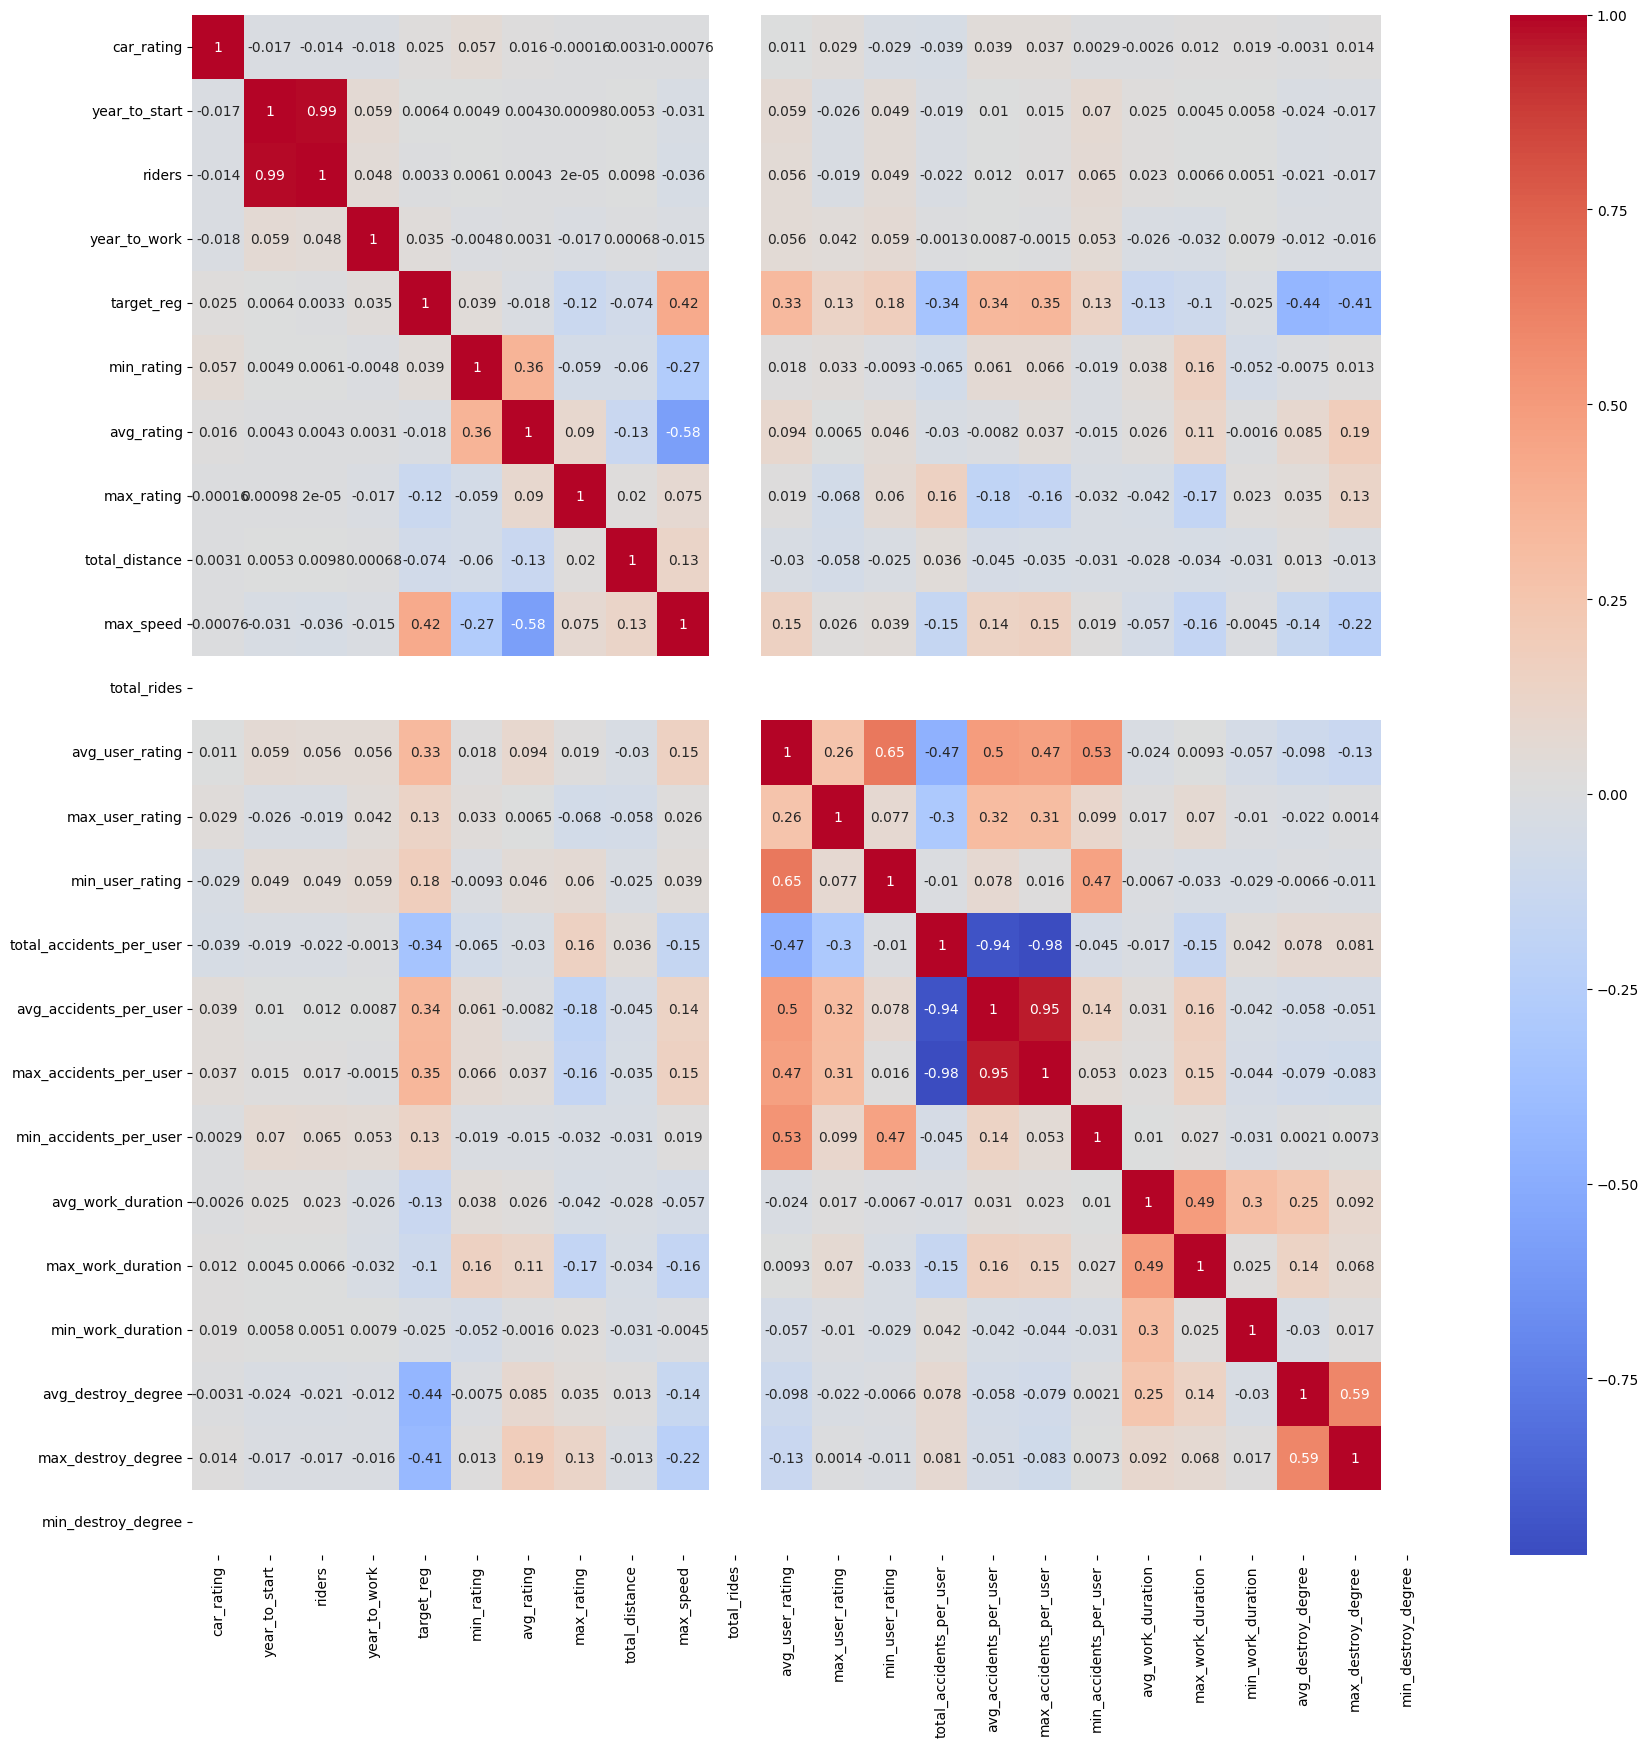

In [11]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

numeric_cols = car_train_merged.select_dtypes(include=[np.number]).columns
correlation_matrix = car_train_merged[numeric_cols].corr()

fig, ax = plt.subplots(figsize=(20, 20))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', ax=ax)
plt.show()


## 2. Permutation Importance

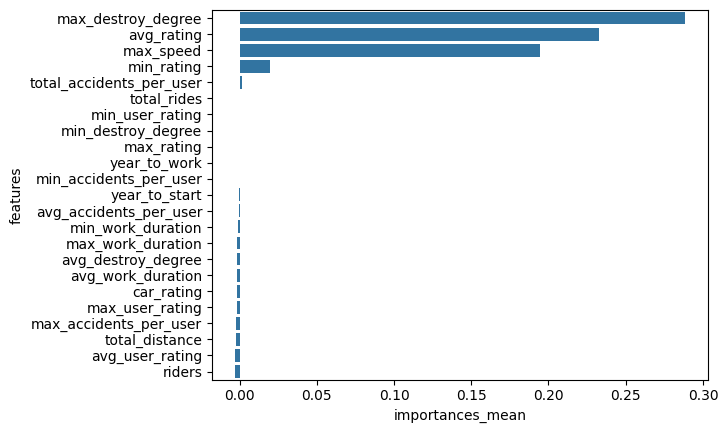

In [12]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.inspection import permutation_importance

X = car_train_merged[numeric_cols]
X.pop('target_reg')
y = car_train_merged['target_class']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

result = permutation_importance(model, X_test, y_test, n_repeats=10, random_state=42)
df_importances_mean = pd.DataFrame(
                        data=list(zip(result.importances_mean, X.columns)),
                        columns=['importances_mean', 'features']).sort_values(
                                        by='importances_mean', ascending=False)

sns.barplot(x=df_importances_mean['importances_mean'], y=df_importances_mean['features'])
plt.show()

## 3. SHAP

In [13]:
# !pip install shap -q

In [14]:
# import shap

# explainer = shap.TreeExplainer(model)
# shap_values = explainer.shap_values(X_test)

# shap.initjs()
# shap.force_plot(explainer.expected_value[0], shap_values[0], X_test.iloc[0])


![](https://github.com/rufous86/mipt_semester4/blob/main/competitive_ds/assets/shap_res.png?raw=1)

# Домашнее задание 2. Прогноз времени и вида поломки машин. Настройка ML-модели

<div class="alert alert-info">

**Цель блока** — составить тренировочную и валидационную выборки, произвести обучение модели `CatBoostClassifier` на тренировочной части и оценить качество на валидационной.

##Обучение первой модели (5 баллов)

1.   Новый пункт
2.   Новый пункт



1. Классифицируйте признаки на типы (категориальные, числовые, таргеты).

2. Выделите в `X` только признаки, а в `y` таргет (для задачи классификации).

3. Сделайте разделение данных на *обучающую* и *валидационную* выборки (не забывайте про воспроизводимость результатов).

4. Создайте и обучите `CatBoostClassifier` модель (настраивать гиперпараметры сейчас не обязательно).

5. Проведите оценку вашей модели, используя метрику `accuracy`.


<h4> Критерии оценивания </h4>
    
- По 1 баллу за каждый корректно выполненный пункт.

</div>

In [15]:
!pip install catboost -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.5/98.5 MB 5.4 MB/s eta 0:00:00


In [16]:
from catboost import CatBoostClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

In [17]:
df_importances_mean[df_importances_mean['importances_mean'] <= 0]['features'].tolist()

['total_rides',
 'min_user_rating',
 'min_destroy_degree',
 'max_rating',
 'year_to_work',
 'min_accidents_per_user',
 'year_to_start',
 'avg_accidents_per_user',
 'min_work_duration',
 'max_work_duration',
 'avg_destroy_degree',
 'avg_work_duration',
 'car_rating',
 'max_user_rating',
 'max_accidents_per_user',
 'total_distance',
 'avg_user_rating',
 'riders']

In [18]:
df_importances_mean[df_importances_mean['importances_mean'] > 0]['features'].tolist()

['max_destroy_degree',
 'avg_rating',
 'max_speed',
 'min_rating',
 'total_accidents_per_user']

In [19]:
car_train_merged.select_dtypes(include=['object']).columns

Index(['car_id', 'model', 'car_type', 'fuel_type', 'target_class'], dtype='object')

In [20]:
features2drop = [
    'total_rides',
    'min_user_rating',
    'min_destroy_degree',
    'max_rating',
    'year_to_work',
    'min_accidents_per_user',
    'year_to_start',
    'avg_accidents_per_user',
    'min_work_duration',
    'max_work_duration',
    'avg_destroy_degree',
    'avg_work_duration',
    'car_rating',
    'max_user_rating',
    'max_accidents_per_user',
    'total_distance',
    'avg_user_rating',
    'riders',
    'car_id'
    ] # то, что надо выбросить

targets = ['target_class'] # таргеты
cat_features = ['model', 'car_type', 'fuel_type'] # категориальные признаки

num_features = [
    'max_destroy_degree',
    'avg_rating',
    'max_speed',
    'min_rating',
    'total_accidents_per_user'
] # числовые признаки

print('Категориальные признаки:', len(cat_features), cat_features)
print('Числовые признаки:', len(num_features), num_features)
print('Целевые переменные', targets)

Категориальные признаки: 3 ['model', 'car_type', 'fuel_type']
Числовые признаки: 5 ['max_destroy_degree', 'avg_rating', 'max_speed', 'min_rating', 'total_accidents_per_user']
Целевые переменные ['target_class']


In [21]:
# YOUR CODE HERE
X = car_train_merged[num_features+cat_features].drop(features2drop, axis=1, errors="ignore")
y = car_train_merged[targets]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
clf = CatBoostClassifier(thread_count=-1,
                         random_seed=42,
                         cat_features=cat_features)

clf.fit(
    X_train,
    y_train,
    eval_set=(X_test, y_test),
    verbose=200,
    use_best_model=True,
    plot=False,
    early_stopping_rounds=100,
)

y_pred = clf.predict(X_test, prediction_type='Class')
print('accuracy:', accuracy_score(y_test, y_pred))

Learning rate set to 0.109335
0:	learn: 1.7115572	test: 1.7094573	best: 1.7094573 (0)	total: 109ms	remaining: 1m 48s
200:	learn: 0.0236301	test: 0.0509749	best: 0.0507846 (197)	total: 21.3s	remaining: 1m 24s
400:	learn: 0.0107460	test: 0.0485416	best: 0.0480115 (346)	total: 41.5s	remaining: 1m 2s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.04801150562
bestIteration = 346

Shrink model to first 347 iterations.
accuracy: 0.9871794871794872


# Дополнительное задание. Визуализация прогнозов, ошибок модели и важности признаков

<div class="alert alert-info">

**Цель блока** — визуализировать результаты прогнозирования, ошибки модели и важность признаков для лучшего понимания и анализа модели.

## Визуализация (5 баллов)

   
1. Визуализируйте важность признаков встроенным методом в `CatBoost`  (помните, что не стоит сильно доверять этому рейтингу важности, т. к. для сильно скоррелированных признаков важность делится пополам — оба признака могут улететь вниз).

2. Постройте `waterfall_plot` из библиотеки `SHAP` (подробнее во втором ноутбуке из полезных ссылок ниже).
    
3. Постройте `classification_report` из библиотеки `scikit-learn`.

4. Постройте и визуализируйте матрицу смежности (`confusion_matrix`), посмотрите, в каких классах модель больше всего ошибается.
    
5. Для каждого графика/примененного метода проинтерпретируйте результаты и сделайте выводы.


<h4> Критерии оценивания </h4>
    
- По 1 баллу за каждый корректно выполненный пункт.
    
</div>

<div class="alert alert-success">

Визуализация может помочь даже после того, как мы **уже обучили** какую-нибудь модель. Например:

- Понять, что мешает модели или чего не хватает, чтобы не допускать ошибки.
- Сделать выводы, как можно улучшить точность в последующих экспериментах.
- Визуализировать ошибки модели.
- Отсеять лишние признаки.
- Найти идеи для новых признаков.
- Все зависит от типа ваших данных.

<h3> Полезные источники </h3>
    
- Занятие про визуализацию и Seaborn.
- Занятие про продвинутую визуализацию и анализ ошибок модели.

</div>    

In [22]:
# YOUR CODE HERE
clf.get_feature_importance(prettified=True)

,Feature Id,Importances
0,total_accidents_per_user,29.158346
1,max_destroy_degree,23.654901
2,max_speed,18.431958
3,avg_rating,16.277508
4,min_rating,8.960065
5,model,2.330494
6,car_type,1.164471
7,fuel_type,0.022258


In [23]:
from sklearn.metrics import classification_report, confusion_matrix

print(classification_report(y_test, y_pred))

                 precision    recall  f1-score   support

    another_bug       0.96      0.95      0.96        58
      break_bug       1.00      1.00      1.00        56
    electro_bug       1.00      1.00      1.00        51
   engine_check       1.00      1.00      1.00        49
    engine_fuel       0.97      1.00      0.98        58
engine_ignition       0.98      1.00      0.99        58
engine_overheat       1.00      0.98      0.99        48
     gear_stick       1.00      1.00      1.00        51
    wheel_shake       0.97      0.95      0.96        39

       accuracy                           0.99       468
      macro avg       0.99      0.99      0.99       468
   weighted avg       0.99      0.99      0.99       468



In [25]:
y_test

,target_class
1720,engine_fuel
2025,electro_bug
1430,engine_overheat
2320,engine_ignition
2141,engine_ignition
...,...
1646,another_bug
1960,engine_overheat
1075,gear_stick
1185,engine_fuel


<Axes: >

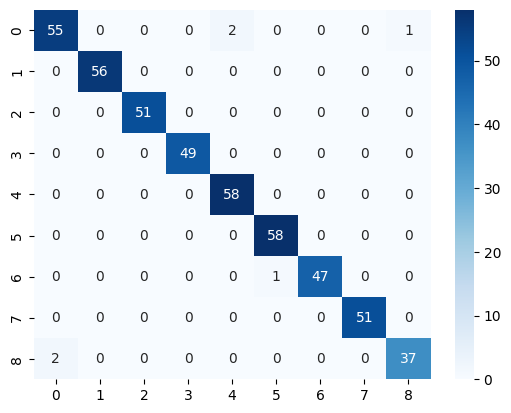

In [26]:
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, cmap='Blues')

Вывод: catboost из коробки показал очень хорошее качество. Судя по confusion matrix имеют место единичные ошибки в классификации

# Домашнее задание 3. Оптимизация. Тюнинг гиперпараметров с помощью `Optuna`

<div class="alert alert-info">

**Цель блока** — улучшить качество предсказания, произведя подбор гиперпараметров для модели с помощью `Optuna`.

## Подбор гиперпараметров (3 балла)

1. Напишите `objective` функцию и запустите `Optuna`.
2. Подберите гиперпараметры для `CatBoostClassifier` (минимум 3).
3. Обучите модель с новыми гиперпараметрами, сравните качество и сделайте выводы.

    
<h4> Критерии оценивания </h4>
    
- 1 балл за каждый корректно выполненный пункт.
    
</div>

In [27]:
!pip install optuna -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 379.9/379.9 kB 2.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.4/233.4 kB 15.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.7/78.7 kB 7.4 MB/s eta 0:00:00


In [34]:
cat_features

['model', 'car_type', 'fuel_type']

In [42]:
# YOUR CODE HERE
import optuna

def objective(trial):
    learning_rate = trial.suggest_loguniform('learning_rate', 0.01, 0.3)
    depth = trial.suggest_int('depth', 1, 10)
    l2_leaf_reg = trial.suggest_loguniform('l2_leaf_reg', 1e-9, 10)

    clf = CatBoostClassifier(learning_rate=learning_rate,
                             depth=depth,
                             l2_leaf_reg=l2_leaf_reg,
                             thread_count=-1,
                            random_seed=42,
                            cat_features=cat_features)

    clf.fit(
        X_train,
        y_train,
        eval_set=(X_test, y_test),
        verbose=200,
        use_best_model=True,
        plot=False,
        early_stopping_rounds=100,
    )

    y_pred = clf.predict(X_test, prediction_type='Class')

    return accuracy_score(y_test, y_pred)

study = optuna.create_study(direction='maximize')

study.optimize(objective, n_trials=100, show_progress_bar=True)

print("Лучшие гиперпараметры: ", study.best_params)

[I 2024-03-30 06:56:08,375] A new study created in memory with name: no-name-9f3a4622-1776-4ce2-9d3b-c871f72523f0


  0%|          | 0/100 [00:00<?, ?it/s]

<ipython-input-42-612747a26970>:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 0.01, 0.3)
<ipython-input-42-612747a26970>:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  l2_leaf_reg = trial.suggest_loguniform('l2_leaf_reg', 1e-9, 10)


0:	learn: 1.1787579	test: 1.1935348	best: 1.1935348 (0)	total: 27.4ms	remaining: 27.4s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.05470757373
bestIteration = 79

Shrink model to first 80 iterations.
[I 2024-03-30 06:56:13,335] Trial 0 finished with value: 0.9807692307692307 and parameters: {'learning_rate': 0.2759022154746358, 'depth': 3, 'l2_leaf_reg': 0.28904778097362943}. Best is trial 0 with value: 0.9807692307692307.


<ipython-input-42-612747a26970>:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 0.01, 0.3)
<ipython-input-42-612747a26970>:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  l2_leaf_reg = trial.suggest_loguniform('l2_leaf_reg', 1e-9, 10)


0:	learn: 1.0162081	test: 1.0472886	best: 1.0472886 (0)	total: 509ms	remaining: 8m 28s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.05084071368
bestIteration = 48

Shrink model to first 49 iterations.
[I 2024-03-30 06:56:58,831] Trial 1 finished with value: 0.9829059829059829 and parameters: {'learning_rate': 0.18248823001959769, 'depth': 10, 'l2_leaf_reg': 3.4726497681277195e-08}. Best is trial 1 with value: 0.9829059829059829.
0:	learn: 1.9933710	test: 1.9949901	best: 1.9949901 (0)	total: 9.28ms	remaining: 9.27s


<ipython-input-42-612747a26970>:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 0.01, 0.3)
<ipython-input-42-612747a26970>:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  l2_leaf_reg = trial.suggest_loguniform('l2_leaf_reg', 1e-9, 10)


200:	learn: 0.0413755	test: 0.0606427	best: 0.0606427 (200)	total: 2.23s	remaining: 8.88s
400:	learn: 0.0205335	test: 0.0502812	best: 0.0499497 (370)	total: 3.88s	remaining: 5.8s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.04927653004
bestIteration = 430

Shrink model to first 431 iterations.
[I 2024-03-30 06:57:03,944] Trial 2 finished with value: 0.9807692307692307 and parameters: {'learning_rate': 0.0712151310675213, 'depth': 2, 'l2_leaf_reg': 0.000887853565782291}. Best is trial 1 with value: 0.9829059829059829.
0:	learn: 1.9509438	test: 1.9533555	best: 1.9533555 (0)	total: 14.3ms	remaining: 14.2s


<ipython-input-42-612747a26970>:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 0.01, 0.3)
<ipython-input-42-612747a26970>:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  l2_leaf_reg = trial.suggest_loguniform('l2_leaf_reg', 1e-9, 10)


200:	learn: 0.0364905	test: 0.0564012	best: 0.0563141 (199)	total: 2.68s	remaining: 10.7s
400:	learn: 0.0146279	test: 0.0497101	best: 0.0494203 (387)	total: 5.67s	remaining: 8.46s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.04898775992
bestIteration = 410

Shrink model to first 411 iterations.
[I 2024-03-30 06:57:11,857] Trial 3 finished with value: 0.9829059829059829 and parameters: {'learning_rate': 0.0545629197112954, 'depth': 3, 'l2_leaf_reg': 3.257438274567595e-05}. Best is trial 1 with value: 0.9829059829059829.
0:	learn: 2.1240633	test: 2.1236857	best: 2.1236857 (0)	total: 85.9ms	remaining: 1m 25s


<ipython-input-42-612747a26970>:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 0.01, 0.3)
<ipython-input-42-612747a26970>:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  l2_leaf_reg = trial.suggest_loguniform('l2_leaf_reg', 1e-9, 10)


200:	learn: 0.1316338	test: 0.1416140	best: 0.1416140 (200)	total: 15.7s	remaining: 1m 2s
400:	learn: 0.0568758	test: 0.0737497	best: 0.0737497 (400)	total: 32.6s	remaining: 48.7s
600:	learn: 0.0417447	test: 0.0631914	best: 0.0631914 (600)	total: 48.1s	remaining: 31.9s
800:	learn: 0.0327120	test: 0.0582835	best: 0.0582835 (800)	total: 1m 5s	remaining: 16.3s
999:	learn: 0.0269734	test: 0.0558848	best: 0.0558848 (999)	total: 1m 23s	remaining: 0us

bestTest = 0.05588477569
bestIteration = 999

[I 2024-03-30 06:58:35,334] Trial 4 finished with value: 0.9871794871794872 and parameters: {'learning_rate': 0.014287440807095627, 'depth': 8, 'l2_leaf_reg': 3.280732121924567}. Best is trial 4 with value: 0.9871794871794872.
0:	learn: 1.8863402	test: 1.8917169	best: 1.8917169 (0)	total: 52.8ms	remaining: 52.8s


<ipython-input-42-612747a26970>:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 0.01, 0.3)
<ipython-input-42-612747a26970>:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  l2_leaf_reg = trial.suggest_loguniform('l2_leaf_reg', 1e-9, 10)


200:	learn: 0.0136322	test: 0.0514330	best: 0.0511866 (185)	total: 11.6s	remaining: 46.3s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.05113855494
bestIteration = 205

Shrink model to first 206 iterations.
[I 2024-03-30 06:58:55,307] Trial 5 finished with value: 0.9871794871794872 and parameters: {'learning_rate': 0.042686636531393235, 'depth': 7, 'l2_leaf_reg': 4.772028167633157e-06}. Best is trial 4 with value: 0.9871794871794872.


<ipython-input-42-612747a26970>:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 0.01, 0.3)
<ipython-input-42-612747a26970>:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  l2_leaf_reg = trial.suggest_loguniform('l2_leaf_reg', 1e-9, 10)


0:	learn: 2.1068584	test: 2.1089892	best: 2.1089892 (0)	total: 145ms	remaining: 2m 25s
200:	learn: 0.1118099	test: 0.1340058	best: 0.1340058 (200)	total: 24.9s	remaining: 1m 39s
400:	learn: 0.0272074	test: 0.0602287	best: 0.0602287 (400)	total: 52.6s	remaining: 1m 18s
600:	learn: 0.0122873	test: 0.0536304	best: 0.0534532 (594)	total: 1m 17s	remaining: 51.4s
800:	learn: 0.0046843	test: 0.0540435	best: 0.0530521 (700)	total: 1m 48s	remaining: 27s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.05305213259
bestIteration = 700

Shrink model to first 701 iterations.
[I 2024-03-30 07:00:44,356] Trial 6 finished with value: 0.9829059829059829 and parameters: {'learning_rate': 0.012170648443000682, 'depth': 9, 'l2_leaf_reg': 1.2593856330958755e-05}. Best is trial 4 with value: 0.9871794871794872.
0:	learn: 2.1535206	test: 2.1539043	best: 2.1539043 (0)	total: 4.93ms	remaining: 4.92s


<ipython-input-42-612747a26970>:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 0.01, 0.3)
<ipython-input-42-612747a26970>:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  l2_leaf_reg = trial.suggest_loguniform('l2_leaf_reg', 1e-9, 10)


200:	learn: 0.2641427	test: 0.2757862	best: 0.2757862 (200)	total: 1.02s	remaining: 4.06s
400:	learn: 0.0823753	test: 0.0940778	best: 0.0940778 (400)	total: 2.79s	remaining: 4.17s
600:	learn: 0.0541297	test: 0.0681901	best: 0.0681901 (600)	total: 3.96s	remaining: 2.63s
800:	learn: 0.0410557	test: 0.0574400	best: 0.0574400 (800)	total: 4.86s	remaining: 1.21s
999:	learn: 0.0332595	test: 0.0519396	best: 0.0519396 (999)	total: 5.75s	remaining: 0us

bestTest = 0.05193955986
bestIteration = 999

[I 2024-03-30 07:00:50,306] Trial 7 finished with value: 0.9850427350427351 and parameters: {'learning_rate': 0.04358972037458477, 'depth': 1, 'l2_leaf_reg': 5.262306441252311e-09}. Best is trial 4 with value: 0.9871794871794872.


<ipython-input-42-612747a26970>:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 0.01, 0.3)
<ipython-input-42-612747a26970>:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  l2_leaf_reg = trial.suggest_loguniform('l2_leaf_reg', 1e-9, 10)


0:	learn: 2.0892001	test: 2.0907868	best: 2.0907868 (0)	total: 263ms	remaining: 4m 23s
200:	learn: 0.0720971	test: 0.0986336	best: 0.0986336 (200)	total: 44.1s	remaining: 2m 55s
400:	learn: 0.0182171	test: 0.0571261	best: 0.0571261 (400)	total: 1m 32s	remaining: 2m 18s
600:	learn: 0.0066826	test: 0.0544675	best: 0.0540017 (558)	total: 2m 25s	remaining: 1m 36s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.05400173529
bestIteration = 558

Shrink model to first 559 iterations.
[I 2024-03-30 07:03:34,835] Trial 8 finished with value: 0.9829059829059829 and parameters: {'learning_rate': 0.014970445494394672, 'depth': 10, 'l2_leaf_reg': 0.07866316337437101}. Best is trial 4 with value: 0.9871794871794872.
0:	learn: 1.7990822	test: 1.8027504	best: 1.8027504 (0)	total: 10.5ms	remaining: 10.5s


<ipython-input-42-612747a26970>:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 0.01, 0.3)
<ipython-input-42-612747a26970>:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  l2_leaf_reg = trial.suggest_loguniform('l2_leaf_reg', 1e-9, 10)


200:	learn: 0.0194576	test: 0.0505849	best: 0.0504013 (199)	total: 1.75s	remaining: 6.96s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.05026617376
bestIteration = 204

Shrink model to first 205 iterations.
[I 2024-03-30 07:03:37,579] Trial 9 finished with value: 0.9829059829059829 and parameters: {'learning_rate': 0.14692194953753232, 'depth': 2, 'l2_leaf_reg': 0.000459099860748059}. Best is trial 4 with value: 0.9871794871794872.
0:	learn: 2.1093534	test: 2.1109810	best: 2.1109810 (0)	total: 59ms	remaining: 58.9s


<ipython-input-42-612747a26970>:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 0.01, 0.3)
<ipython-input-42-612747a26970>:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  l2_leaf_reg = trial.suggest_loguniform('l2_leaf_reg', 1e-9, 10)


200:	learn: 0.1024419	test: 0.1149157	best: 0.1149157 (200)	total: 12.8s	remaining: 51s
400:	learn: 0.0568727	test: 0.0733591	best: 0.0733561 (399)	total: 24.1s	remaining: 36.1s
600:	learn: 0.0469363	test: 0.0663597	best: 0.0663597 (600)	total: 35s	remaining: 23.2s
800:	learn: 0.0413563	test: 0.0624088	best: 0.0624088 (800)	total: 44.9s	remaining: 11.2s
999:	learn: 0.0382897	test: 0.0606352	best: 0.0606180 (974)	total: 55.6s	remaining: 0us

bestTest = 0.06061798306
bestIteration = 974

Shrink model to first 975 iterations.
[I 2024-03-30 07:04:33,416] Trial 10 finished with value: 0.9850427350427351 and parameters: {'learning_rate': 0.021154915821265552, 'depth': 6, 'l2_leaf_reg': 9.658779265715424}. Best is trial 4 with value: 0.9871794871794872.
0:	learn: 2.0182983	test: 2.0213654	best: 2.0213654 (0)	total: 55.5ms	remaining: 55.4s


<ipython-input-42-612747a26970>:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 0.01, 0.3)
<ipython-input-42-612747a26970>:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  l2_leaf_reg = trial.suggest_loguniform('l2_leaf_reg', 1e-9, 10)


200:	learn: 0.0333074	test: 0.0606804	best: 0.0606804 (200)	total: 11.6s	remaining: 46s
400:	learn: 0.0093631	test: 0.0521910	best: 0.0516487 (368)	total: 22.8s	remaining: 34.1s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.05164871888
bestIteration = 368

Shrink model to first 369 iterations.
[I 2024-03-30 07:05:00,180] Trial 11 finished with value: 0.9871794871794872 and parameters: {'learning_rate': 0.024302635136119362, 'depth': 7, 'l2_leaf_reg': 1.0483992003524149e-06}. Best is trial 4 with value: 0.9871794871794872.


<ipython-input-42-612747a26970>:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 0.01, 0.3)
<ipython-input-42-612747a26970>:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  l2_leaf_reg = trial.suggest_loguniform('l2_leaf_reg', 1e-9, 10)


0:	learn: 1.9611700	test: 1.9654761	best: 1.9654761 (0)	total: 123ms	remaining: 2m 3s
200:	learn: 0.0177408	test: 0.0546667	best: 0.0546667 (200)	total: 17.5s	remaining: 1m 9s
400:	learn: 0.0021750	test: 0.0551879	best: 0.0516023 (308)	total: 35.5s	remaining: 53s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.05160227993
bestIteration = 308

Shrink model to first 309 iterations.
[I 2024-03-30 07:05:36,565] Trial 12 finished with value: 0.9829059829059829 and parameters: {'learning_rate': 0.03216523544532083, 'depth': 8, 'l2_leaf_reg': 3.2061796631711754e-07}. Best is trial 4 with value: 0.9871794871794872.
0:	learn: 1.6423855	test: 1.6478932	best: 1.6478932 (0)	total: 34ms	remaining: 33.9s


<ipython-input-42-612747a26970>:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 0.01, 0.3)
<ipython-input-42-612747a26970>:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  l2_leaf_reg = trial.suggest_loguniform('l2_leaf_reg', 1e-9, 10)


200:	learn: 0.0054941	test: 0.0535554	best: 0.0517094 (130)	total: 7.37s	remaining: 29.3s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.05170943519
bestIteration = 130

Shrink model to first 131 iterations.
[I 2024-03-30 07:05:44,999] Trial 13 finished with value: 0.9871794871794872 and parameters: {'learning_rate': 0.09062343272131006, 'depth': 5, 'l2_leaf_reg': 0.010620010803024245}. Best is trial 4 with value: 0.9871794871794872.
0:	learn: 2.1391666	test: 2.1392183	best: 2.1392183 (0)	total: 31.9ms	remaining: 31.9s


<ipython-input-42-612747a26970>:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 0.01, 0.3)
<ipython-input-42-612747a26970>:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  l2_leaf_reg = trial.suggest_loguniform('l2_leaf_reg', 1e-9, 10)


200:	learn: 0.1788416	test: 0.1914241	best: 0.1914241 (200)	total: 9.01s	remaining: 35.8s
400:	learn: 0.0723290	test: 0.0877322	best: 0.0877322 (400)	total: 15.3s	remaining: 22.9s
600:	learn: 0.0564464	test: 0.0736498	best: 0.0736483 (599)	total: 21.7s	remaining: 14.4s
800:	learn: 0.0480444	test: 0.0668192	best: 0.0668192 (800)	total: 26.8s	remaining: 6.65s
999:	learn: 0.0427991	test: 0.0628201	best: 0.0628201 (999)	total: 32.8s	remaining: 0us

bestTest = 0.06282014042
bestIteration = 999

[I 2024-03-30 07:06:18,101] Trial 14 finished with value: 0.9829059829059829 and parameters: {'learning_rate': 0.012303510096718893, 'depth': 5, 'l2_leaf_reg': 5.139642494121232}. Best is trial 4 with value: 0.9871794871794872.


<ipython-input-42-612747a26970>:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 0.01, 0.3)
<ipython-input-42-612747a26970>:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  l2_leaf_reg = trial.suggest_loguniform('l2_leaf_reg', 1e-9, 10)


0:	learn: 1.9404386	test: 1.9448630	best: 1.9448630 (0)	total: 89.2ms	remaining: 1m 29s
200:	learn: 0.0209123	test: 0.0543033	best: 0.0543033 (200)	total: 10.1s	remaining: 40.2s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.05102430062
bestIteration = 288

Shrink model to first 289 iterations.
[I 2024-03-30 07:06:39,744] Trial 15 finished with value: 0.9871794871794872 and parameters: {'learning_rate': 0.035096744809419586, 'depth': 7, 'l2_leaf_reg': 3.87392602360957e-06}. Best is trial 4 with value: 0.9871794871794872.
0:	learn: 2.0651205	test: 2.0674134	best: 2.0674134 (0)	total: 90.5ms	remaining: 1m 30s


<ipython-input-42-612747a26970>:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 0.01, 0.3)
<ipython-input-42-612747a26970>:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  l2_leaf_reg = trial.suggest_loguniform('l2_leaf_reg', 1e-9, 10)


200:	learn: 0.0518748	test: 0.0766152	best: 0.0766152 (200)	total: 17.2s	remaining: 1m 8s
400:	learn: 0.0157964	test: 0.0540932	best: 0.0540800 (399)	total: 32.7s	remaining: 48.9s
600:	learn: 0.0050793	test: 0.0525806	best: 0.0522268 (576)	total: 50.8s	remaining: 33.7s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.05222679039
bestIteration = 576

Shrink model to first 577 iterations.
[I 2024-03-30 07:07:38,596] Trial 16 finished with value: 0.9850427350427351 and parameters: {'learning_rate': 0.01789457901615132, 'depth': 8, 'l2_leaf_reg': 0.00731731522475346}. Best is trial 4 with value: 0.9871794871794872.
0:	learn: 2.1299942	test: 2.1305802	best: 2.1305802 (0)	total: 57.6ms	remaining: 57.6s


<ipython-input-42-612747a26970>:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 0.01, 0.3)
<ipython-input-42-612747a26970>:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  l2_leaf_reg = trial.suggest_loguniform('l2_leaf_reg', 1e-9, 10)


200:	learn: 0.1587374	test: 0.1747772	best: 0.1747772 (200)	total: 12.8s	remaining: 50.9s
400:	learn: 0.0508967	test: 0.0727074	best: 0.0727074 (400)	total: 24.7s	remaining: 36.8s
600:	learn: 0.0312689	test: 0.0581966	best: 0.0581966 (600)	total: 36.5s	remaining: 24.3s
800:	learn: 0.0194810	test: 0.0524435	best: 0.0524435 (800)	total: 48s	remaining: 11.9s
999:	learn: 0.0121021	test: 0.0506892	best: 0.0504935 (968)	total: 1m	remaining: 0us

bestTest = 0.05049347957
bestIteration = 968

Shrink model to first 969 iterations.
[I 2024-03-30 07:08:39,193] Trial 17 finished with value: 0.9850427350427351 and parameters: {'learning_rate': 0.01038021312639118, 'depth': 6, 'l2_leaf_reg': 1.1005044989287016e-07}. Best is trial 4 with value: 0.9871794871794872.


<ipython-input-42-612747a26970>:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 0.01, 0.3)
<ipython-input-42-612747a26970>:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  l2_leaf_reg = trial.suggest_loguniform('l2_leaf_reg', 1e-9, 10)


0:	learn: 1.6032530	test: 1.6143859	best: 1.6143859 (0)	total: 90.3ms	remaining: 1m 30s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.05163628581
bestIteration = 84

Shrink model to first 85 iterations.
[I 2024-03-30 07:08:55,632] Trial 18 finished with value: 0.9850427350427351 and parameters: {'learning_rate': 0.0837637374364675, 'depth': 8, 'l2_leaf_reg': 1.5751228653360374e-09}. Best is trial 4 with value: 0.9871794871794872.
0:	learn: 2.0394150	test: 2.0416792	best: 2.0416792 (0)	total: 24ms	remaining: 24s


<ipython-input-42-612747a26970>:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 0.01, 0.3)
<ipython-input-42-612747a26970>:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  l2_leaf_reg = trial.suggest_loguniform('l2_leaf_reg', 1e-9, 10)


200:	learn: 0.0544017	test: 0.0729281	best: 0.0729281 (200)	total: 3.95s	remaining: 15.7s
400:	learn: 0.0239412	test: 0.0516726	best: 0.0516726 (400)	total: 8.73s	remaining: 13s
600:	learn: 0.0123134	test: 0.0499098	best: 0.0491850 (581)	total: 12.5s	remaining: 8.27s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.04918497862
bestIteration = 581

Shrink model to first 582 iterations.
[I 2024-03-30 07:09:09,840] Trial 19 finished with value: 0.9829059829059829 and parameters: {'learning_rate': 0.026593530501602198, 'depth': 4, 'l2_leaf_reg': 0.00011832422560421192}. Best is trial 4 with value: 0.9871794871794872.


<ipython-input-42-612747a26970>:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 0.01, 0.3)
<ipython-input-42-612747a26970>:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  l2_leaf_reg = trial.suggest_loguniform('l2_leaf_reg', 1e-9, 10)


0:	learn: 1.4075226	test: 1.3966444	best: 1.3966444 (0)	total: 160ms	remaining: 2m 40s
200:	learn: 0.0037150	test: 0.0583457	best: 0.0534282 (102)	total: 30.8s	remaining: 2m 2s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.05342818631
bestIteration = 102

Shrink model to first 103 iterations.
[I 2024-03-30 07:09:41,346] Trial 20 finished with value: 0.9829059829059829 and parameters: {'learning_rate': 0.1335252255406598, 'depth': 9, 'l2_leaf_reg': 0.8466551542066426}. Best is trial 4 with value: 0.9871794871794872.


<ipython-input-42-612747a26970>:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 0.01, 0.3)
<ipython-input-42-612747a26970>:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  l2_leaf_reg = trial.suggest_loguniform('l2_leaf_reg', 1e-9, 10)


0:	learn: 2.0185257	test: 2.0215888	best: 2.0215888 (0)	total: 109ms	remaining: 1m 48s
200:	learn: 0.0341278	test: 0.0619818	best: 0.0619818 (200)	total: 10.6s	remaining: 41.9s
400:	learn: 0.0091788	test: 0.0522722	best: 0.0521764 (397)	total: 21.8s	remaining: 32.6s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.05185688031
bestIteration = 410

Shrink model to first 411 iterations.
[I 2024-03-30 07:10:10,596] Trial 21 finished with value: 0.9871794871794872 and parameters: {'learning_rate': 0.024271323784628575, 'depth': 7, 'l2_leaf_reg': 1.3576258870702736e-06}. Best is trial 4 with value: 0.9871794871794872.
0:	learn: 2.0687542	test: 2.0709495	best: 2.0709495 (0)	total: 55ms	remaining: 54.9s


<ipython-input-42-612747a26970>:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 0.01, 0.3)
<ipython-input-42-612747a26970>:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  l2_leaf_reg = trial.suggest_loguniform('l2_leaf_reg', 1e-9, 10)


200:	learn: 0.0562827	test: 0.0789213	best: 0.0789213 (200)	total: 11.4s	remaining: 45.2s
400:	learn: 0.0204343	test: 0.0551705	best: 0.0551042 (398)	total: 23.2s	remaining: 34.7s
600:	learn: 0.0076504	test: 0.0526660	best: 0.0524162 (571)	total: 34.5s	remaining: 22.9s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.05241615533
bestIteration = 571

Shrink model to first 572 iterations.
[I 2024-03-30 07:10:49,767] Trial 22 finished with value: 0.9850427350427351 and parameters: {'learning_rate': 0.017382623237052443, 'depth': 7, 'l2_leaf_reg': 9.409474730811213e-07}. Best is trial 4 with value: 0.9871794871794872.
0:	learn: 1.9221614	test: 1.9246619	best: 1.9246619 (0)	total: 56.1ms	remaining: 56.1s


<ipython-input-42-612747a26970>:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 0.01, 0.3)
<ipython-input-42-612747a26970>:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  l2_leaf_reg = trial.suggest_loguniform('l2_leaf_reg', 1e-9, 10)


200:	learn: 0.0177173	test: 0.0521940	best: 0.0521940 (200)	total: 12s	remaining: 47.7s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.05131394195
bestIteration = 289

Shrink model to first 290 iterations.
[I 2024-03-30 07:11:13,981] Trial 23 finished with value: 0.9829059829059829 and parameters: {'learning_rate': 0.04326750383598484, 'depth': 6, 'l2_leaf_reg': 1.805219241250872e-08}. Best is trial 4 with value: 0.9871794871794872.
0:	learn: 1.9764831	test: 1.9802772	best: 1.9802772 (0)	total: 60.4ms	remaining: 1m


<ipython-input-42-612747a26970>:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 0.01, 0.3)
<ipython-input-42-612747a26970>:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  l2_leaf_reg = trial.suggest_loguniform('l2_leaf_reg', 1e-9, 10)


200:	learn: 0.0261683	test: 0.0580226	best: 0.0580226 (200)	total: 10.9s	remaining: 43.4s
400:	learn: 0.0045411	test: 0.0526192	best: 0.0513271 (360)	total: 23s	remaining: 34.4s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.05132706128
bestIteration = 360

Shrink model to first 361 iterations.
[I 2024-03-30 07:11:40,540] Trial 24 finished with value: 0.9829059829059829 and parameters: {'learning_rate': 0.030081549442546707, 'depth': 7, 'l2_leaf_reg': 8.931841701952899e-06}. Best is trial 4 with value: 0.9871794871794872.


<ipython-input-42-612747a26970>:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 0.01, 0.3)
<ipython-input-42-612747a26970>:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  l2_leaf_reg = trial.suggest_loguniform('l2_leaf_reg', 1e-9, 10)


0:	learn: 2.0425928	test: 2.0462430	best: 2.0462430 (0)	total: 148ms	remaining: 2m 28s
200:	learn: 0.0356163	test: 0.0662488	best: 0.0662488 (200)	total: 27.3s	remaining: 1m 48s
400:	learn: 0.0077882	test: 0.0533618	best: 0.0533618 (400)	total: 54.6s	remaining: 1m 21s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.05336181443
bestIteration = 400

Shrink model to first 401 iterations.
[I 2024-03-30 07:12:52,883] Trial 25 finished with value: 0.9850427350427351 and parameters: {'learning_rate': 0.020926908049590454, 'depth': 9, 'l2_leaf_reg': 0.00022099926720066645}. Best is trial 4 with value: 0.9871794871794872.


<ipython-input-42-612747a26970>:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 0.01, 0.3)
<ipython-input-42-612747a26970>:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  l2_leaf_reg = trial.suggest_loguniform('l2_leaf_reg', 1e-9, 10)


0:	learn: 1.8771210	test: 1.8828574	best: 1.8828574 (0)	total: 154ms	remaining: 2m 33s
200:	learn: 0.0087843	test: 0.0527313	best: 0.0521972 (195)	total: 17s	remaining: 1m 7s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.05171587759
bestIteration = 241

Shrink model to first 242 iterations.
[I 2024-03-30 07:13:23,619] Trial 26 finished with value: 0.9850427350427351 and parameters: {'learning_rate': 0.043982424245213605, 'depth': 8, 'l2_leaf_reg': 0.0040372780377311195}. Best is trial 4 with value: 0.9871794871794872.
0:	learn: 2.1018863	test: 2.1027597	best: 2.1027597 (0)	total: 36.1ms	remaining: 36s


<ipython-input-42-612747a26970>:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 0.01, 0.3)
<ipython-input-42-612747a26970>:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  l2_leaf_reg = trial.suggest_loguniform('l2_leaf_reg', 1e-9, 10)


200:	learn: 0.0926563	test: 0.1092956	best: 0.1092956 (200)	total: 7.18s	remaining: 28.6s
400:	learn: 0.0387716	test: 0.0621075	best: 0.0621075 (400)	total: 13.6s	remaining: 20.3s
600:	learn: 0.0238584	test: 0.0538265	best: 0.0538265 (600)	total: 20s	remaining: 13.3s
800:	learn: 0.0142656	test: 0.0507958	best: 0.0505630 (763)	total: 26.6s	remaining: 6.61s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.05021291802
bestIteration = 887

Shrink model to first 888 iterations.
[I 2024-03-30 07:13:57,490] Trial 27 finished with value: 0.9871794871794872 and parameters: {'learning_rate': 0.0148187016002715, 'depth': 5, 'l2_leaf_reg': 5.613303262950334e-05}. Best is trial 4 with value: 0.9871794871794872.


<ipython-input-42-612747a26970>:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 0.01, 0.3)
<ipython-input-42-612747a26970>:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  l2_leaf_reg = trial.suggest_loguniform('l2_leaf_reg', 1e-9, 10)


0:	learn: 1.7400709	test: 1.7480654	best: 1.7480654 (0)	total: 63.4ms	remaining: 1m 3s
200:	learn: 0.0040609	test: 0.0560547	best: 0.0522293 (154)	total: 11s	remaining: 43.6s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.05222931587
bestIteration = 154

Shrink model to first 155 iterations.
[I 2024-03-30 07:14:12,384] Trial 28 finished with value: 0.9850427350427351 and parameters: {'learning_rate': 0.06362993466713776, 'depth': 7, 'l2_leaf_reg': 1.895270559717689e-07}. Best is trial 4 with value: 0.9871794871794872.
0:	learn: 2.1374989	test: 2.1383249	best: 2.1383249 (0)	total: 24.8ms	remaining: 24.8s


<ipython-input-42-612747a26970>:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 0.01, 0.3)
<ipython-input-42-612747a26970>:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  l2_leaf_reg = trial.suggest_loguniform('l2_leaf_reg', 1e-9, 10)


200:	learn: 0.2400265	test: 0.2541834	best: 0.2541834 (200)	total: 4.07s	remaining: 16.2s
400:	learn: 0.0782457	test: 0.0936601	best: 0.0936601 (400)	total: 8.24s	remaining: 12.3s
600:	learn: 0.0510349	test: 0.0686836	best: 0.0686836 (600)	total: 12.8s	remaining: 8.48s
800:	learn: 0.0378771	test: 0.0589110	best: 0.0589110 (800)	total: 16.3s	remaining: 4.04s
999:	learn: 0.0287947	test: 0.0538608	best: 0.0538608 (999)	total: 20s	remaining: 0us

bestTest = 0.05386080614
bestIteration = 999

[I 2024-03-30 07:14:32,567] Trial 29 finished with value: 0.9850427350427351 and parameters: {'learning_rate': 0.010019846002668026, 'depth': 4, 'l2_leaf_reg': 0.057390883091577666}. Best is trial 4 with value: 0.9871794871794872.


<ipython-input-42-612747a26970>:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 0.01, 0.3)
<ipython-input-42-612747a26970>:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  l2_leaf_reg = trial.suggest_loguniform('l2_leaf_reg', 1e-9, 10)


0:	learn: 0.6396971	test: 0.6824323	best: 0.6824323 (0)	total: 160ms	remaining: 2m 39s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.06709026702
bestIteration = 25

Shrink model to first 26 iterations.
[I 2024-03-30 07:14:52,234] Trial 30 finished with value: 0.9807692307692307 and parameters: {'learning_rate': 0.26924683116129683, 'depth': 9, 'l2_leaf_reg': 1.8173423560166597e-06}. Best is trial 4 with value: 0.9871794871794872.
0:	learn: 1.6387670	test: 1.6414321	best: 1.6414321 (0)	total: 38.4ms	remaining: 38.4s


<ipython-input-42-612747a26970>:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 0.01, 0.3)
<ipython-input-42-612747a26970>:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  l2_leaf_reg = trial.suggest_loguniform('l2_leaf_reg', 1e-9, 10)


200:	learn: 0.0156475	test: 0.0542669	best: 0.0535184 (176)	total: 5.91s	remaining: 23.5s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.05213921468
bestIteration = 242

Shrink model to first 243 iterations.
[I 2024-03-30 07:15:03,714] Trial 31 finished with value: 0.9871794871794872 and parameters: {'learning_rate': 0.09844136101488155, 'depth': 5, 'l2_leaf_reg': 0.8900047017952736}. Best is trial 4 with value: 0.9871794871794872.
0:	learn: 1.5752143	test: 1.5812679	best: 1.5812679 (0)	total: 54.6ms	remaining: 54.6s


<ipython-input-42-612747a26970>:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 0.01, 0.3)
<ipython-input-42-612747a26970>:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  l2_leaf_reg = trial.suggest_loguniform('l2_leaf_reg', 1e-9, 10)


200:	learn: 0.0019573	test: 0.0546255	best: 0.0480648 (123)	total: 13.4s	remaining: 53.4s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.04806482345
bestIteration = 123

Shrink model to first 124 iterations.
[I 2024-03-30 07:15:18,636] Trial 32 finished with value: 0.9850427350427351 and parameters: {'learning_rate': 0.10213361430247793, 'depth': 6, 'l2_leaf_reg': 0.009208179823735469}. Best is trial 4 with value: 0.9871794871794872.
0:	learn: 1.8621537	test: 1.8670625	best: 1.8670625 (0)	total: 24.6ms	remaining: 24.6s


<ipython-input-42-612747a26970>:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 0.01, 0.3)
<ipython-input-42-612747a26970>:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  l2_leaf_reg = trial.suggest_loguniform('l2_leaf_reg', 1e-9, 10)


200:	learn: 0.0226879	test: 0.0509084	best: 0.0508216 (199)	total: 3.77s	remaining: 15s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.04913580348
bestIteration = 273

Shrink model to first 274 iterations.
[I 2024-03-30 07:15:25,783] Trial 33 finished with value: 0.9829059829059829 and parameters: {'learning_rate': 0.05753284314662508, 'depth': 4, 'l2_leaf_reg': 0.0016040165931623595}. Best is trial 4 with value: 0.9871794871794872.


<ipython-input-42-612747a26970>:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 0.01, 0.3)
<ipython-input-42-612747a26970>:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  l2_leaf_reg = trial.suggest_loguniform('l2_leaf_reg', 1e-9, 10)


0:	learn: 1.9279200	test: 1.9306300	best: 1.9306300 (0)	total: 129ms	remaining: 2m 8s
200:	learn: 0.0203458	test: 0.0531666	best: 0.0531666 (200)	total: 16.9s	remaining: 1m 6s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.04975850602
bestIteration = 299

Shrink model to first 300 iterations.
[I 2024-03-30 07:16:01,210] Trial 34 finished with value: 0.9850427350427351 and parameters: {'learning_rate': 0.037978716765488425, 'depth': 8, 'l2_leaf_reg': 0.1403093940361066}. Best is trial 4 with value: 0.9871794871794872.


<ipython-input-42-612747a26970>:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 0.01, 0.3)
<ipython-input-42-612747a26970>:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  l2_leaf_reg = trial.suggest_loguniform('l2_leaf_reg', 1e-9, 10)


0:	learn: 1.6322343	test: 1.6463269	best: 1.6463269 (0)	total: 263ms	remaining: 4m 22s
200:	learn: 0.0002074	test: 0.0687807	best: 0.0549149 (108)	total: 50.9s	remaining: 3m 22s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.05491489832
bestIteration = 108

Shrink model to first 109 iterations.
[I 2024-03-30 07:16:54,319] Trial 35 finished with value: 0.9829059829059829 and parameters: {'learning_rate': 0.07935749529248677, 'depth': 10, 'l2_leaf_reg': 2.0714979338887016e-05}. Best is trial 4 with value: 0.9871794871794872.
0:	learn: 1.8847636	test: 1.8876524	best: 1.8876524 (0)	total: 32.4ms	remaining: 32.4s


<ipython-input-42-612747a26970>:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 0.01, 0.3)
<ipython-input-42-612747a26970>:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  l2_leaf_reg = trial.suggest_loguniform('l2_leaf_reg', 1e-9, 10)


200:	learn: 0.0200444	test: 0.0539695	best: 0.0537160 (197)	total: 7.31s	remaining: 29s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.05230889323
bestIteration = 271

Shrink model to first 272 iterations.
[I 2024-03-30 07:17:07,062] Trial 36 finished with value: 0.9850427350427351 and parameters: {'learning_rate': 0.04964943849768168, 'depth': 5, 'l2_leaf_reg': 0.015876353438388627}. Best is trial 4 with value: 0.9871794871794872.
0:	learn: 2.0868648	test: 2.0876833	best: 2.0876833 (0)	total: 14.9ms	remaining: 14.9s


<ipython-input-42-612747a26970>:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 0.01, 0.3)
<ipython-input-42-612747a26970>:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  l2_leaf_reg = trial.suggest_loguniform('l2_leaf_reg', 1e-9, 10)


200:	learn: 0.0881621	test: 0.1016867	best: 0.1016867 (200)	total: 4.06s	remaining: 16.1s
400:	learn: 0.0455516	test: 0.0621639	best: 0.0621639 (400)	total: 6.62s	remaining: 9.88s
600:	learn: 0.0342467	test: 0.0547361	best: 0.0546859 (596)	total: 9.08s	remaining: 6.03s
800:	learn: 0.0275066	test: 0.0513570	best: 0.0513570 (800)	total: 11.6s	remaining: 2.87s
999:	learn: 0.0230998	test: 0.0504427	best: 0.0502770 (976)	total: 14.8s	remaining: 0us

bestTest = 0.05027695667
bestIteration = 976

Shrink model to first 977 iterations.
[I 2024-03-30 07:17:22,142] Trial 37 finished with value: 0.9871794871794872 and parameters: {'learning_rate': 0.025045525430952773, 'depth': 3, 'l2_leaf_reg': 1.0018214970582386}. Best is trial 4 with value: 0.9871794871794872.


<ipython-input-42-612747a26970>:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 0.01, 0.3)
<ipython-input-42-612747a26970>:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  l2_leaf_reg = trial.suggest_loguniform('l2_leaf_reg', 1e-9, 10)


0:	learn: 1.7710827	test: 1.7750836	best: 1.7750836 (0)	total: 104ms	remaining: 1m 43s
200:	learn: 0.0064301	test: 0.0528692	best: 0.0492694 (145)	total: 12.6s	remaining: 50s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.04926940501
bestIteration = 145

Shrink model to first 146 iterations.
[I 2024-03-30 07:17:38,355] Trial 38 finished with value: 0.9871794871794872 and parameters: {'learning_rate': 0.06813840743104696, 'depth': 6, 'l2_leaf_reg': 0.0014676016340947366}. Best is trial 4 with value: 0.9871794871794872.
0:	learn: 1.3302344	test: 1.3450840	best: 1.3450840 (0)	total: 55.5ms	remaining: 55.5s


<ipython-input-42-612747a26970>:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 0.01, 0.3)
<ipython-input-42-612747a26970>:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  l2_leaf_reg = trial.suggest_loguniform('l2_leaf_reg', 1e-9, 10)


Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.05097028393
bestIteration = 85

Shrink model to first 86 iterations.
[I 2024-03-30 07:17:49,703] Trial 39 finished with value: 0.9850427350427351 and parameters: {'learning_rate': 0.12788856595344886, 'depth': 7, 'l2_leaf_reg': 0.03727824568365746}. Best is trial 4 with value: 0.9871794871794872.


<ipython-input-42-612747a26970>:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 0.01, 0.3)
<ipython-input-42-612747a26970>:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  l2_leaf_reg = trial.suggest_loguniform('l2_leaf_reg', 1e-9, 10)


0:	learn: 0.8009429	test: 0.8379043	best: 0.8379043 (0)	total: 156ms	remaining: 2m 35s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.05955581701
bestIteration = 36

Shrink model to first 37 iterations.
[I 2024-03-30 07:18:09,998] Trial 40 finished with value: 0.9850427350427351 and parameters: {'learning_rate': 0.2280945091392357, 'depth': 9, 'l2_leaf_reg': 3.81801418818297e-08}. Best is trial 4 with value: 0.9871794871794872.
0:	learn: 1.9285563	test: 1.9331891	best: 1.9331891 (0)	total: 53.9ms	remaining: 53.8s


<ipython-input-42-612747a26970>:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 0.01, 0.3)
<ipython-input-42-612747a26970>:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  l2_leaf_reg = trial.suggest_loguniform('l2_leaf_reg', 1e-9, 10)


200:	learn: 0.0199021	test: 0.0549139	best: 0.0549139 (200)	total: 10.9s	remaining: 43.2s
400:	learn: 0.0024026	test: 0.0548953	best: 0.0520992 (333)	total: 22.7s	remaining: 34s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.05209921981
bestIteration = 333

Shrink model to first 334 iterations.
[I 2024-03-30 07:18:34,775] Trial 41 finished with value: 0.9829059829059829 and parameters: {'learning_rate': 0.03675723337547922, 'depth': 7, 'l2_leaf_reg': 6.131550262081578e-06}. Best is trial 4 with value: 0.9871794871794872.
0:	learn: 1.9607372	test: 1.9650512	best: 1.9650512 (0)	total: 90.5ms	remaining: 1m 30s


<ipython-input-42-612747a26970>:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 0.01, 0.3)
<ipython-input-42-612747a26970>:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  l2_leaf_reg = trial.suggest_loguniform('l2_leaf_reg', 1e-9, 10)


200:	learn: 0.0195643	test: 0.0551278	best: 0.0551278 (200)	total: 16.1s	remaining: 1m 3s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.05316246188
bestIteration = 278

Shrink model to first 279 iterations.
[I 2024-03-30 07:19:08,026] Trial 42 finished with value: 0.9829059829059829 and parameters: {'learning_rate': 0.032225372835196775, 'depth': 8, 'l2_leaf_reg': 3.297292160458331e-06}. Best is trial 4 with value: 0.9871794871794872.
0:	learn: 2.0402299	test: 2.0429173	best: 2.0429173 (0)	total: 55.1ms	remaining: 55.1s


<ipython-input-42-612747a26970>:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 0.01, 0.3)
<ipython-input-42-612747a26970>:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  l2_leaf_reg = trial.suggest_loguniform('l2_leaf_reg', 1e-9, 10)


200:	learn: 0.0408188	test: 0.0651606	best: 0.0651606 (200)	total: 11.2s	remaining: 44.4s
400:	learn: 0.0131299	test: 0.0503784	best: 0.0503709 (389)	total: 22s	remaining: 32.8s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.04983020513
bestIteration = 412

Shrink model to first 413 iterations.
[I 2024-03-30 07:19:36,542] Trial 43 finished with value: 0.9871794871794872 and parameters: {'learning_rate': 0.021287805444519355, 'depth': 7, 'l2_leaf_reg': 5.208164093115034e-07}. Best is trial 4 with value: 0.9871794871794872.
0:	learn: 2.1102322	test: 2.1109923	best: 2.1109923 (0)	total: 72.4ms	remaining: 1m 12s


<ipython-input-42-612747a26970>:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 0.01, 0.3)
<ipython-input-42-612747a26970>:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  l2_leaf_reg = trial.suggest_loguniform('l2_leaf_reg', 1e-9, 10)


200:	learn: 0.0980377	test: 0.1156265	best: 0.1156265 (200)	total: 12.8s	remaining: 50.8s
400:	learn: 0.0354955	test: 0.0613793	best: 0.0613793 (400)	total: 25.4s	remaining: 37.9s
600:	learn: 0.0207976	test: 0.0540021	best: 0.0540021 (600)	total: 36.4s	remaining: 24.2s
800:	learn: 0.0111231	test: 0.0521321	best: 0.0517609 (755)	total: 48.8s	remaining: 12.1s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.0517609363
bestIteration = 755

Shrink model to first 756 iterations.
[I 2024-03-30 07:20:28,751] Trial 44 finished with value: 0.9871794871794872 and parameters: {'learning_rate': 0.013454180900047191, 'depth': 6, 'l2_leaf_reg': 0.00029847589069843296}. Best is trial 4 with value: 0.9871794871794872.


<ipython-input-42-612747a26970>:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 0.01, 0.3)
<ipython-input-42-612747a26970>:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  l2_leaf_reg = trial.suggest_loguniform('l2_leaf_reg', 1e-9, 10)


0:	learn: 2.0662422	test: 2.0686155	best: 2.0686155 (0)	total: 91.2ms	remaining: 1m 31s
200:	learn: 0.0539720	test: 0.0786954	best: 0.0786954 (200)	total: 15.5s	remaining: 1m 1s
400:	learn: 0.0169286	test: 0.0537062	best: 0.0537062 (400)	total: 32.3s	remaining: 48.3s
600:	learn: 0.0049559	test: 0.0522816	best: 0.0513192 (531)	total: 50.3s	remaining: 33.4s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.05131915358
bestIteration = 531

Shrink model to first 532 iterations.
[I 2024-03-30 07:21:21,976] Trial 45 finished with value: 0.9850427350427351 and parameters: {'learning_rate': 0.017702574792766906, 'depth': 8, 'l2_leaf_reg': 3.5300161913445803e-05}. Best is trial 4 with value: 0.9871794871794872.
0:	learn: 1.8684504	test: 1.8716005	best: 1.8716005 (0)	total: 31.8ms	remaining: 31.7s


<ipython-input-42-612747a26970>:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 0.01, 0.3)
<ipython-input-42-612747a26970>:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  l2_leaf_reg = trial.suggest_loguniform('l2_leaf_reg', 1e-9, 10)


200:	learn: 0.0178524	test: 0.0535294	best: 0.0532623 (198)	total: 7.07s	remaining: 28.1s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.05223396689
bestIteration = 246

Shrink model to first 247 iterations.
[I 2024-03-30 07:21:33,770] Trial 46 finished with value: 0.9871794871794872 and parameters: {'learning_rate': 0.052230371101891174, 'depth': 5, 'l2_leaf_reg': 5.2272821234362105e-08}. Best is trial 4 with value: 0.9871794871794872.
0:	learn: 2.1177800	test: 2.1183602	best: 2.1183602 (0)	total: 9.54ms	remaining: 9.53s


<ipython-input-42-612747a26970>:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 0.01, 0.3)
<ipython-input-42-612747a26970>:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  l2_leaf_reg = trial.suggest_loguniform('l2_leaf_reg', 1e-9, 10)


200:	learn: 0.1576669	test: 0.1687925	best: 0.1687925 (200)	total: 2.4s	remaining: 9.53s
400:	learn: 0.0651566	test: 0.0791548	best: 0.0791548 (400)	total: 4.7s	remaining: 7.01s
600:	learn: 0.0489193	test: 0.0643386	best: 0.0643376 (599)	total: 6.33s	remaining: 4.2s
800:	learn: 0.0415358	test: 0.0590083	best: 0.0590083 (800)	total: 7.96s	remaining: 1.98s
999:	learn: 0.0365749	test: 0.0551457	best: 0.0551378 (998)	total: 9.57s	remaining: 0us

bestTest = 0.05513779234
bestIteration = 998

Shrink model to first 999 iterations.
[I 2024-03-30 07:21:43,576] Trial 47 finished with value: 0.9850427350427351 and parameters: {'learning_rate': 0.028977633859899203, 'depth': 2, 'l2_leaf_reg': 2.4851559993319805}. Best is trial 4 with value: 0.9871794871794872.
0:	learn: 1.9576402	test: 1.9587065	best: 1.9587065 (0)	total: 56.2ms	remaining: 56.1s


<ipython-input-42-612747a26970>:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 0.01, 0.3)
<ipython-input-42-612747a26970>:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  l2_leaf_reg = trial.suggest_loguniform('l2_leaf_reg', 1e-9, 10)


200:	learn: 0.0290583	test: 0.0554797	best: 0.0553831 (198)	total: 11.6s	remaining: 46.3s
400:	learn: 0.0094703	test: 0.0504935	best: 0.0504935 (400)	total: 23.6s	remaining: 35.3s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.05049354022
bestIteration = 400

Shrink model to first 401 iterations.
[I 2024-03-30 07:22:12,976] Trial 48 finished with value: 0.9850427350427351 and parameters: {'learning_rate': 0.03918086986068115, 'depth': 6, 'l2_leaf_reg': 0.24035943486973502}. Best is trial 4 with value: 0.9871794871794872.


<ipython-input-42-612747a26970>:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 0.01, 0.3)
<ipython-input-42-612747a26970>:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  l2_leaf_reg = trial.suggest_loguniform('l2_leaf_reg', 1e-9, 10)


0:	learn: 2.0472675	test: 2.0498333	best: 2.0498333 (0)	total: 100ms	remaining: 1m 40s
200:	learn: 0.0453273	test: 0.0697026	best: 0.0697026 (200)	total: 12.4s	remaining: 49.3s
400:	learn: 0.0152862	test: 0.0519200	best: 0.0518217 (399)	total: 23.4s	remaining: 34.9s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.05063222932
bestIteration = 481

Shrink model to first 482 iterations.
[I 2024-03-30 07:22:47,505] Trial 49 finished with value: 0.9850427350427351 and parameters: {'learning_rate': 0.020322675768942877, 'depth': 7, 'l2_leaf_reg': 4.6148648368648846e-06}. Best is trial 4 with value: 0.9871794871794872.


<ipython-input-42-612747a26970>:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 0.01, 0.3)
<ipython-input-42-612747a26970>:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  l2_leaf_reg = trial.suggest_loguniform('l2_leaf_reg', 1e-9, 10)


0:	learn: 1.1557776	test: 1.1819868	best: 1.1819868 (0)	total: 169ms	remaining: 2m 48s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.05775203125
bestIteration = 50

Shrink model to first 51 iterations.
[I 2024-03-30 07:23:10,380] Trial 50 finished with value: 0.9829059829059829 and parameters: {'learning_rate': 0.15653911118462277, 'depth': 9, 'l2_leaf_reg': 2.192196902436037e-05}. Best is trial 4 with value: 0.9871794871794872.
0:	learn: 2.0266645	test: 2.0295866	best: 2.0295866 (0)	total: 64.8ms	remaining: 1m 4s


<ipython-input-42-612747a26970>:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 0.01, 0.3)
<ipython-input-42-612747a26970>:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  l2_leaf_reg = trial.suggest_loguniform('l2_leaf_reg', 1e-9, 10)


200:	learn: 0.0345019	test: 0.0621930	best: 0.0621930 (200)	total: 11.3s	remaining: 44.9s
400:	learn: 0.0108167	test: 0.0517645	best: 0.0512710 (366)	total: 21.7s	remaining: 32.4s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.05127099951
bestIteration = 366

Shrink model to first 367 iterations.
[I 2024-03-30 07:23:36,367] Trial 51 finished with value: 0.9871794871794872 and parameters: {'learning_rate': 0.023151296321931285, 'depth': 7, 'l2_leaf_reg': 1.2668331434409672e-06}. Best is trial 4 with value: 0.9871794871794872.
0:	learn: 1.9522881	test: 1.9567588	best: 1.9567588 (0)	total: 85.1ms	remaining: 1m 25s


<ipython-input-42-612747a26970>:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 0.01, 0.3)
<ipython-input-42-612747a26970>:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  l2_leaf_reg = trial.suggest_loguniform('l2_leaf_reg', 1e-9, 10)


200:	learn: 0.0175476	test: 0.0519974	best: 0.0519837 (197)	total: 15.8s	remaining: 1m 2s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.05099442733
bestIteration = 281

Shrink model to first 282 iterations.
[I 2024-03-30 07:24:08,796] Trial 52 finished with value: 0.9850427350427351 and parameters: {'learning_rate': 0.03339973291802995, 'depth': 8, 'l2_leaf_reg': 4.72712051642295e-07}. Best is trial 4 with value: 0.9871794871794872.


<ipython-input-42-612747a26970>:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 0.01, 0.3)
<ipython-input-42-612747a26970>:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  l2_leaf_reg = trial.suggest_loguniform('l2_leaf_reg', 1e-9, 10)


0:	learn: 2.0216872	test: 2.0232493	best: 2.0232493 (0)	total: 83ms	remaining: 1m 22s
200:	learn: 0.0361897	test: 0.0604820	best: 0.0604757 (199)	total: 12.1s	remaining: 48.2s
400:	learn: 0.0109069	test: 0.0496308	best: 0.0494869 (386)	total: 23.9s	remaining: 35.7s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.04939526868
bestIteration = 423

Shrink model to first 424 iterations.
[I 2024-03-30 07:24:42,386] Trial 53 finished with value: 0.9871794871794872 and parameters: {'learning_rate': 0.027354788210558874, 'depth': 6, 'l2_leaf_reg': 2.435062902042958e-06}. Best is trial 4 with value: 0.9871794871794872.
0:	learn: 2.1109852	test: 2.1124550	best: 2.1124550 (0)	total: 63.8ms	remaining: 1m 3s


<ipython-input-42-612747a26970>:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 0.01, 0.3)
<ipython-input-42-612747a26970>:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  l2_leaf_reg = trial.suggest_loguniform('l2_leaf_reg', 1e-9, 10)


200:	learn: 0.1259460	test: 0.1456191	best: 0.1456191 (200)	total: 11.1s	remaining: 44.2s
400:	learn: 0.0378611	test: 0.0645586	best: 0.0645586 (400)	total: 22.3s	remaining: 33.4s
600:	learn: 0.0211496	test: 0.0546423	best: 0.0546415 (599)	total: 31.8s	remaining: 21.1s
800:	learn: 0.0113792	test: 0.0524761	best: 0.0524606 (799)	total: 43.3s	remaining: 10.8s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.05190044877
bestIteration = 872

Shrink model to first 873 iterations.
[I 2024-03-30 07:25:36,662] Trial 54 finished with value: 0.9850427350427351 and parameters: {'learning_rate': 0.011632575710156506, 'depth': 7, 'l2_leaf_reg': 1.1905377379510621e-07}. Best is trial 4 with value: 0.9871794871794872.


<ipython-input-42-612747a26970>:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 0.01, 0.3)
<ipython-input-42-612747a26970>:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  l2_leaf_reg = trial.suggest_loguniform('l2_leaf_reg', 1e-9, 10)


0:	learn: 2.0779674	test: 2.0801255	best: 2.0801255 (0)	total: 93.1ms	remaining: 1m 32s
200:	learn: 0.0623549	test: 0.0875599	best: 0.0875599 (200)	total: 16.6s	remaining: 1m 5s
400:	learn: 0.0188039	test: 0.0570699	best: 0.0570699 (400)	total: 33s	remaining: 49.3s
600:	learn: 0.0065261	test: 0.0540303	best: 0.0537786 (573)	total: 51s	remaining: 33.8s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.0537785711
bestIteration = 573

Shrink model to first 574 iterations.
[I 2024-03-30 07:26:35,333] Trial 55 finished with value: 0.9850427350427351 and parameters: {'learning_rate': 0.016104325573600833, 'depth': 8, 'l2_leaf_reg': 0.0001266927778793629}. Best is trial 4 with value: 0.9871794871794872.
0:	learn: 2.0105466	test: 2.0137482	best: 2.0137482 (0)	total: 55.8ms	remaining: 55.7s


<ipython-input-42-612747a26970>:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 0.01, 0.3)
<ipython-input-42-612747a26970>:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  l2_leaf_reg = trial.suggest_loguniform('l2_leaf_reg', 1e-9, 10)


200:	learn: 0.0331170	test: 0.0613760	best: 0.0613760 (200)	total: 11s	remaining: 43.9s
400:	learn: 0.0080235	test: 0.0530285	best: 0.0528205 (328)	total: 23.6s	remaining: 35.2s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.05266099973
bestIteration = 422

Shrink model to first 423 iterations.
[I 2024-03-30 07:27:06,249] Trial 56 finished with value: 0.9850427350427351 and parameters: {'learning_rate': 0.025370830470340867, 'depth': 7, 'l2_leaf_reg': 1.2671968204200667e-08}. Best is trial 4 with value: 0.9871794871794872.
0:	learn: 1.9235719	test: 1.9260588	best: 1.9260588 (0)	total: 57.2ms	remaining: 57.1s


<ipython-input-42-612747a26970>:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 0.01, 0.3)
<ipython-input-42-612747a26970>:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  l2_leaf_reg = trial.suggest_loguniform('l2_leaf_reg', 1e-9, 10)


200:	learn: 0.0183285	test: 0.0526002	best: 0.0526002 (200)	total: 11.9s	remaining: 47.2s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.04972787454
bestIteration = 264

Shrink model to first 265 iterations.
[I 2024-03-30 07:27:28,853] Trial 57 finished with value: 0.9871794871794872 and parameters: {'learning_rate': 0.04303971829515549, 'depth': 6, 'l2_leaf_reg': 8.13148377505451e-06}. Best is trial 4 with value: 0.9871794871794872.
0:	learn: 1.8953296	test: 1.8982057	best: 1.8982057 (0)	total: 34.4ms	remaining: 34.3s


<ipython-input-42-612747a26970>:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 0.01, 0.3)
<ipython-input-42-612747a26970>:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  l2_leaf_reg = trial.suggest_loguniform('l2_leaf_reg', 1e-9, 10)


200:	learn: 0.0210492	test: 0.0533089	best: 0.0533089 (200)	total: 6.23s	remaining: 24.8s
400:	learn: 0.0041699	test: 0.0515134	best: 0.0490330 (307)	total: 13.3s	remaining: 19.9s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.04903295258
bestIteration = 307

Shrink model to first 308 iterations.
[I 2024-03-30 07:27:42,524] Trial 58 finished with value: 0.9850427350427351 and parameters: {'learning_rate': 0.047827725957805885, 'depth': 5, 'l2_leaf_reg': 8.767318779388664e-07}. Best is trial 4 with value: 0.9871794871794872.
0:	learn: 1.9353321	test: 1.9401176	best: 1.9401176 (0)	total: 84.3ms	remaining: 1m 24s


<ipython-input-42-612747a26970>:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 0.01, 0.3)
<ipython-input-42-612747a26970>:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  l2_leaf_reg = trial.suggest_loguniform('l2_leaf_reg', 1e-9, 10)


200:	learn: 0.0157670	test: 0.0530241	best: 0.0530241 (200)	total: 15.5s	remaining: 1m 1s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.05018046776
bestIteration = 269

Shrink model to first 270 iterations.
[I 2024-03-30 07:28:15,018] Trial 59 finished with value: 0.9850427350427351 and parameters: {'learning_rate': 0.03576197544380968, 'depth': 8, 'l2_leaf_reg': 2.1382235964504063e-07}. Best is trial 4 with value: 0.9871794871794872.
0:	learn: 1.8359593	test: 1.8412741	best: 1.8412741 (0)	total: 38.2ms	remaining: 38.1s


<ipython-input-42-612747a26970>:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 0.01, 0.3)
<ipython-input-42-612747a26970>:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  l2_leaf_reg = trial.suggest_loguniform('l2_leaf_reg', 1e-9, 10)


200:	learn: 0.0198966	test: 0.0494499	best: 0.0494499 (200)	total: 3.86s	remaining: 15.3s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.04664683993
bestIteration = 260

Shrink model to first 261 iterations.
[I 2024-03-30 07:28:22,054] Trial 60 finished with value: 0.9850427350427351 and parameters: {'learning_rate': 0.062211661754332945, 'depth': 4, 'l2_leaf_reg': 5.890600084996575e-05}. Best is trial 4 with value: 0.9871794871794872.
0:	learn: 2.1126728	test: 2.1134461	best: 2.1134461 (0)	total: 35.2ms	remaining: 35.1s


<ipython-input-42-612747a26970>:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 0.01, 0.3)
<ipython-input-42-612747a26970>:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  l2_leaf_reg = trial.suggest_loguniform('l2_leaf_reg', 1e-9, 10)


200:	learn: 0.1152463	test: 0.1315041	best: 0.1315041 (200)	total: 7.73s	remaining: 30.7s
400:	learn: 0.0437483	test: 0.0658349	best: 0.0658349 (400)	total: 13.7s	remaining: 20.4s
600:	learn: 0.0278273	test: 0.0558479	best: 0.0558479 (600)	total: 20.2s	remaining: 13.4s
800:	learn: 0.0171571	test: 0.0521508	best: 0.0521482 (799)	total: 26.2s	remaining: 6.51s
999:	learn: 0.0108716	test: 0.0515439	best: 0.0513848 (928)	total: 33.5s	remaining: 0us

bestTest = 0.05138477579
bestIteration = 928

Shrink model to first 929 iterations.
[I 2024-03-30 07:28:55,834] Trial 61 finished with value: 0.9871794871794872 and parameters: {'learning_rate': 0.013130231105241695, 'depth': 5, 'l2_leaf_reg': 1.7863539448749147e-05}. Best is trial 4 with value: 0.9871794871794872.
0:	learn: 2.1822145	test: 2.1823419	best: 2.1823419 (0)	total: 4.96ms	remaining: 4.96s


<ipython-input-42-612747a26970>:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 0.01, 0.3)
<ipython-input-42-612747a26970>:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  l2_leaf_reg = trial.suggest_loguniform('l2_leaf_reg', 1e-9, 10)


200:	learn: 0.8875899	test: 0.8999851	best: 0.8999851 (200)	total: 938ms	remaining: 3.73s
400:	learn: 0.4593685	test: 0.4717162	best: 0.4717162 (400)	total: 1.85s	remaining: 2.77s
600:	learn: 0.2609923	test: 0.2721544	best: 0.2721544 (600)	total: 2.75s	remaining: 1.83s
800:	learn: 0.1617398	test: 0.1729383	best: 0.1729383 (800)	total: 3.68s	remaining: 914ms
999:	learn: 0.1090118	test: 0.1200358	best: 0.1200358 (999)	total: 4.59s	remaining: 0us

bestTest = 0.1200357558
bestIteration = 999

[I 2024-03-30 07:29:00,642] Trial 62 finished with value: 0.9871794871794872 and parameters: {'learning_rate': 0.014752849314153903, 'depth': 1, 'l2_leaf_reg': 0.0008658602534707516}. Best is trial 4 with value: 0.9871794871794872.
0:	learn: 2.1091732	test: 2.1104272	best: 2.1104272 (0)	total: 20.1ms	remaining: 20.1s


<ipython-input-42-612747a26970>:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 0.01, 0.3)
<ipython-input-42-612747a26970>:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  l2_leaf_reg = trial.suggest_loguniform('l2_leaf_reg', 1e-9, 10)


200:	learn: 0.1244954	test: 0.1389844	best: 0.1389844 (200)	total: 5.21s	remaining: 20.7s
400:	learn: 0.0504110	test: 0.0685006	best: 0.0685006 (400)	total: 8.88s	remaining: 13.3s
600:	learn: 0.0327678	test: 0.0558668	best: 0.0558668 (600)	total: 12.4s	remaining: 8.23s
800:	learn: 0.0219732	test: 0.0508257	best: 0.0508032 (785)	total: 17.4s	remaining: 4.33s
999:	learn: 0.0151296	test: 0.0498092	best: 0.0497899 (998)	total: 22.2s	remaining: 0us

bestTest = 0.04978985136
bestIteration = 998

Shrink model to first 999 iterations.
[I 2024-03-30 07:29:23,099] Trial 63 finished with value: 0.9850427350427351 and parameters: {'learning_rate': 0.01474205876331193, 'depth': 4, 'l2_leaf_reg': 8.72633919900628e-05}. Best is trial 4 with value: 0.9871794871794872.
0:	learn: 2.0723108	test: 2.0734612	best: 2.0734612 (0)	total: 31.1ms	remaining: 31.1s


<ipython-input-42-612747a26970>:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 0.01, 0.3)
<ipython-input-42-612747a26970>:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  l2_leaf_reg = trial.suggest_loguniform('l2_leaf_reg', 1e-9, 10)


200:	learn: 0.0608292	test: 0.0801370	best: 0.0801370 (200)	total: 7.02s	remaining: 27.9s
400:	learn: 0.0292746	test: 0.0569158	best: 0.0567087 (399)	total: 13.2s	remaining: 19.7s
600:	learn: 0.0146891	test: 0.0517394	best: 0.0516322 (587)	total: 19.9s	remaining: 13.2s
800:	learn: 0.0076141	test: 0.0516218	best: 0.0510366 (730)	total: 26.6s	remaining: 6.61s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.05103660412
bestIteration = 730

Shrink model to first 731 iterations.
[I 2024-03-30 07:29:50,923] Trial 64 finished with value: 0.9850427350427351 and parameters: {'learning_rate': 0.019464463332078057, 'depth': 5, 'l2_leaf_reg': 1.0308324265994027e-05}. Best is trial 4 with value: 0.9871794871794872.
0:	learn: 2.0955609	test: 2.0973876	best: 2.0973876 (0)	total: 54ms	remaining: 54s


<ipython-input-42-612747a26970>:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 0.01, 0.3)
<ipython-input-42-612747a26970>:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  l2_leaf_reg = trial.suggest_loguniform('l2_leaf_reg', 1e-9, 10)


200:	learn: 0.0869977	test: 0.1000330	best: 0.1000330 (200)	total: 12.5s	remaining: 49.8s
400:	learn: 0.0535826	test: 0.0709967	best: 0.0709920 (399)	total: 22.8s	remaining: 34.1s
600:	learn: 0.0446223	test: 0.0648794	best: 0.0648794 (600)	total: 33.6s	remaining: 22.3s
800:	learn: 0.0385170	test: 0.0610138	best: 0.0610138 (800)	total: 44.5s	remaining: 11s
999:	learn: 0.0351740	test: 0.0591417	best: 0.0591417 (999)	total: 54s	remaining: 0us

bestTest = 0.05914165761
bestIteration = 999

[I 2024-03-30 07:30:45,267] Trial 65 finished with value: 0.9850427350427351 and parameters: {'learning_rate': 0.023454922393818647, 'depth': 6, 'l2_leaf_reg': 8.556631563837266}. Best is trial 4 with value: 0.9871794871794872.


<ipython-input-42-612747a26970>:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 0.01, 0.3)
<ipython-input-42-612747a26970>:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  l2_leaf_reg = trial.suggest_loguniform('l2_leaf_reg', 1e-9, 10)


0:	learn: 2.1150312	test: 2.1164317	best: 2.1164317 (0)	total: 107ms	remaining: 1m 46s
200:	learn: 0.1368259	test: 0.1562999	best: 0.1562999 (200)	total: 10.9s	remaining: 43.3s
400:	learn: 0.0400024	test: 0.0671819	best: 0.0671819 (400)	total: 22.1s	remaining: 33s
600:	learn: 0.0220996	test: 0.0568997	best: 0.0568987 (599)	total: 32.7s	remaining: 21.7s
800:	learn: 0.0121327	test: 0.0539839	best: 0.0536069 (732)	total: 44.3s	remaining: 11s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.05360691842
bestIteration = 732

Shrink model to first 733 iterations.
[I 2024-03-30 07:31:31,633] Trial 66 finished with value: 0.9850427350427351 and parameters: {'learning_rate': 0.011083606523166407, 'depth': 7, 'l2_leaf_reg': 1.973999938720516e-06}. Best is trial 4 with value: 0.9871794871794872.
0:	learn: 2.0046689	test: 2.0063882	best: 2.0063882 (0)	total: 60.7ms	remaining: 1m


<ipython-input-42-612747a26970>:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 0.01, 0.3)
<ipython-input-42-612747a26970>:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  l2_leaf_reg = trial.suggest_loguniform('l2_leaf_reg', 1e-9, 10)


200:	learn: 0.0328069	test: 0.0575594	best: 0.0575594 (200)	total: 13s	remaining: 51.5s
400:	learn: 0.0088389	test: 0.0505444	best: 0.0498290 (389)	total: 24.7s	remaining: 36.9s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.04982900803
bestIteration = 389

Shrink model to first 390 iterations.
[I 2024-03-30 07:32:02,440] Trial 67 finished with value: 0.9871794871794872 and parameters: {'learning_rate': 0.03005332961071728, 'depth': 6, 'l2_leaf_reg': 3.782961694939152e-05}. Best is trial 4 with value: 0.9871794871794872.


<ipython-input-42-612747a26970>:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 0.01, 0.3)
<ipython-input-42-612747a26970>:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  l2_leaf_reg = trial.suggest_loguniform('l2_leaf_reg', 1e-9, 10)


0:	learn: 1.6365733	test: 1.6464640	best: 1.6464640 (0)	total: 99.5ms	remaining: 1m 39s
200:	learn: 0.0016919	test: 0.0562757	best: 0.0503427 (139)	total: 10.6s	remaining: 42.1s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.05034270445
bestIteration = 139

Shrink model to first 140 iterations.
[I 2024-03-30 07:32:16,516] Trial 68 finished with value: 0.9829059829059829 and parameters: {'learning_rate': 0.07888205789218407, 'depth': 7, 'l2_leaf_reg': 8.234677894693489e-07}. Best is trial 4 with value: 0.9871794871794872.
0:	learn: 2.0588408	test: 2.0613409	best: 2.0613409 (0)	total: 98.7ms	remaining: 1m 38s


<ipython-input-42-612747a26970>:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 0.01, 0.3)
<ipython-input-42-612747a26970>:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  l2_leaf_reg = trial.suggest_loguniform('l2_leaf_reg', 1e-9, 10)


200:	learn: 0.0468873	test: 0.0731215	best: 0.0731215 (200)	total: 16s	remaining: 1m 3s
400:	learn: 0.0140169	test: 0.0529443	best: 0.0529228 (399)	total: 31.4s	remaining: 46.9s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.05175271071
bestIteration = 479

Shrink model to first 480 iterations.
[I 2024-03-30 07:33:05,256] Trial 69 finished with value: 0.9850427350427351 and parameters: {'learning_rate': 0.018716415033643064, 'depth': 8, 'l2_leaf_reg': 0.000589153603988945}. Best is trial 4 with value: 0.9871794871794872.
0:	learn: 2.1210293	test: 2.1217413	best: 2.1217413 (0)	total: 24.4ms	remaining: 24.4s


<ipython-input-42-612747a26970>:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 0.01, 0.3)
<ipython-input-42-612747a26970>:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  l2_leaf_reg = trial.suggest_loguniform('l2_leaf_reg', 1e-9, 10)


200:	learn: 0.1683615	test: 0.1810882	best: 0.1810882 (200)	total: 3.27s	remaining: 13s
400:	learn: 0.0625733	test: 0.0773800	best: 0.0773800 (400)	total: 5.92s	remaining: 8.85s
600:	learn: 0.0404842	test: 0.0600977	best: 0.0600977 (600)	total: 8.46s	remaining: 5.61s
800:	learn: 0.0287770	test: 0.0526387	best: 0.0526387 (800)	total: 11.2s	remaining: 2.77s
999:	learn: 0.0218987	test: 0.0501553	best: 0.0501553 (999)	total: 14.7s	remaining: 0us

bestTest = 0.05015533185
bestIteration = 999

[I 2024-03-30 07:33:20,261] Trial 70 finished with value: 0.9850427350427351 and parameters: {'learning_rate': 0.016520163377753076, 'depth': 3, 'l2_leaf_reg': 0.00018110666364486012}. Best is trial 4 with value: 0.9871794871794872.
0:	learn: 1.5373757	test: 1.5420465	best: 1.5420465 (0)	total: 32.1ms	remaining: 32s


<ipython-input-42-612747a26970>:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 0.01, 0.3)
<ipython-input-42-612747a26970>:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  l2_leaf_reg = trial.suggest_loguniform('l2_leaf_reg', 1e-9, 10)


200:	learn: 0.0072393	test: 0.0566255	best: 0.0542660 (107)	total: 5.93s	remaining: 23.6s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.05426604248
bestIteration = 107

Shrink model to first 108 iterations.
[I 2024-03-30 07:33:26,511] Trial 71 finished with value: 0.9871794871794872 and parameters: {'learning_rate': 0.11295065631003647, 'depth': 5, 'l2_leaf_reg': 0.33668509684831366}. Best is trial 4 with value: 0.9871794871794872.
0:	learn: 1.6601602	test: 1.6616576	best: 1.6616576 (0)	total: 31.9ms	remaining: 31.9s


<ipython-input-42-612747a26970>:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 0.01, 0.3)
<ipython-input-42-612747a26970>:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  l2_leaf_reg = trial.suggest_loguniform('l2_leaf_reg', 1e-9, 10)


200:	learn: 0.0275844	test: 0.0563355	best: 0.0562536 (197)	total: 6.77s	remaining: 26.9s
400:	learn: 0.0145377	test: 0.0545123	best: 0.0539432 (361)	total: 12.3s	remaining: 18.4s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.05394324406
bestIteration = 361

Shrink model to first 362 iterations.
[I 2024-03-30 07:33:40,820] Trial 72 finished with value: 0.9871794871794872 and parameters: {'learning_rate': 0.10852666425516559, 'depth': 5, 'l2_leaf_reg': 3.1507469534878236}. Best is trial 4 with value: 0.9871794871794872.
0:	learn: 1.7277125	test: 1.7328357	best: 1.7328357 (0)	total: 20.1ms	remaining: 20.1s


<ipython-input-42-612747a26970>:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 0.01, 0.3)
<ipython-input-42-612747a26970>:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  l2_leaf_reg = trial.suggest_loguniform('l2_leaf_reg', 1e-9, 10)


200:	learn: 0.0229972	test: 0.0497502	best: 0.0490079 (189)	total: 4.79s	remaining: 19s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.04760123879
bestIteration = 272

Shrink model to first 273 iterations.
[I 2024-03-30 07:33:48,812] Trial 73 finished with value: 0.9871794871794872 and parameters: {'learning_rate': 0.08697277959404698, 'depth': 4, 'l2_leaf_reg': 0.9484292202183073}. Best is trial 4 with value: 0.9871794871794872.
0:	learn: 1.3515768	test: 1.3556241	best: 1.3556241 (0)	total: 32.4ms	remaining: 32.4s


<ipython-input-42-612747a26970>:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 0.01, 0.3)
<ipython-input-42-612747a26970>:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  l2_leaf_reg = trial.suggest_loguniform('l2_leaf_reg', 1e-9, 10)


200:	learn: 0.0127680	test: 0.0543523	best: 0.0531346 (179)	total: 6.12s	remaining: 24.3s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.05313464839
bestIteration = 179

Shrink model to first 180 iterations.
[I 2024-03-30 07:33:58,141] Trial 74 finished with value: 0.9871794871794872 and parameters: {'learning_rate': 0.1673892176726466, 'depth': 5, 'l2_leaf_reg': 1.9417867926673968}. Best is trial 4 with value: 0.9871794871794872.
0:	learn: 1.6833321	test: 1.6850545	best: 1.6850545 (0)	total: 54.8ms	remaining: 54.8s


<ipython-input-42-612747a26970>:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 0.01, 0.3)
<ipython-input-42-612747a26970>:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  l2_leaf_reg = trial.suggest_loguniform('l2_leaf_reg', 1e-9, 10)


200:	learn: 0.0086827	test: 0.0531167	best: 0.0507937 (137)	total: 12.9s	remaining: 51.5s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.05079373439
bestIteration = 137

Shrink model to first 138 iterations.
[I 2024-03-30 07:34:13,294] Trial 75 finished with value: 0.9871794871794872 and parameters: {'learning_rate': 0.08912970056599516, 'depth': 6, 'l2_leaf_reg': 0.44026874878302397}. Best is trial 4 with value: 0.9871794871794872.


<ipython-input-42-612747a26970>:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 0.01, 0.3)
<ipython-input-42-612747a26970>:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  l2_leaf_reg = trial.suggest_loguniform('l2_leaf_reg', 1e-9, 10)


0:	learn: 1.8954120	test: 1.9015366	best: 1.9015366 (0)	total: 146ms	remaining: 2m 26s
200:	learn: 0.0084970	test: 0.0529043	best: 0.0528254 (199)	total: 27.5s	remaining: 1m 49s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.05282539671
bestIteration = 199

Shrink model to first 200 iterations.
[I 2024-03-30 07:34:56,428] Trial 76 finished with value: 0.9829059829059829 and parameters: {'learning_rate': 0.041620868562504854, 'depth': 9, 'l2_leaf_reg': 0.01987486425264748}. Best is trial 4 with value: 0.9871794871794872.
0:	learn: 1.5124293	test: 1.5230498	best: 1.5230498 (0)	total: 29.2ms	remaining: 29.1s


<ipython-input-42-612747a26970>:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 0.01, 0.3)
<ipython-input-42-612747a26970>:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  l2_leaf_reg = trial.suggest_loguniform('l2_leaf_reg', 1e-9, 10)


200:	learn: 0.0049827	test: 0.0517279	best: 0.0474669 (134)	total: 4.93s	remaining: 19.6s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.0474668642
bestIteration = 134

Shrink model to first 135 iterations.
[I 2024-03-30 07:35:02,109] Trial 77 finished with value: 0.9829059829059829 and parameters: {'learning_rate': 0.12347124551880517, 'depth': 4, 'l2_leaf_reg': 0.0030462184185198796}. Best is trial 4 with value: 0.9871794871794872.
0:	learn: 1.5371135	test: 1.5488669	best: 1.5488669 (0)	total: 62.5ms	remaining: 1m 2s


<ipython-input-42-612747a26970>:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 0.01, 0.3)
<ipython-input-42-612747a26970>:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  l2_leaf_reg = trial.suggest_loguniform('l2_leaf_reg', 1e-9, 10)


200:	learn: 0.0007749	test: 0.0621854	best: 0.0516468 (107)	total: 11.6s	remaining: 45.9s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.05164676362
bestIteration = 107

Shrink model to first 108 iterations.
[I 2024-03-30 07:35:14,200] Trial 78 finished with value: 0.9850427350427351 and parameters: {'learning_rate': 0.09394349180336398, 'depth': 7, 'l2_leaf_reg': 3.931540562294514e-06}. Best is trial 4 with value: 0.9871794871794872.
0:	learn: 2.0536365	test: 2.0549061	best: 2.0549061 (0)	total: 55ms	remaining: 55s


<ipython-input-42-612747a26970>:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 0.01, 0.3)
<ipython-input-42-612747a26970>:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  l2_leaf_reg = trial.suggest_loguniform('l2_leaf_reg', 1e-9, 10)


200:	learn: 0.0460944	test: 0.0686227	best: 0.0686227 (200)	total: 12.2s	remaining: 48.6s
400:	learn: 0.0173051	test: 0.0536083	best: 0.0536052 (399)	total: 23.4s	remaining: 35s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.05228906537
bestIteration = 472

Shrink model to first 473 iterations.
[I 2024-03-30 07:35:47,543] Trial 79 finished with value: 0.9871794871794872 and parameters: {'learning_rate': 0.022312875754221077, 'depth': 6, 'l2_leaf_reg': 1.3120710446244502e-05}. Best is trial 4 with value: 0.9871794871794872.


<ipython-input-42-612747a26970>:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 0.01, 0.3)
<ipython-input-42-612747a26970>:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  l2_leaf_reg = trial.suggest_loguniform('l2_leaf_reg', 1e-9, 10)


0:	learn: 1.7842041	test: 1.7904244	best: 1.7904244 (0)	total: 89.1ms	remaining: 1m 29s
200:	learn: 0.0079224	test: 0.0540437	best: 0.0526579 (166)	total: 11.3s	remaining: 44.9s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.05265792527
bestIteration = 166

Shrink model to first 167 iterations.
[I 2024-03-30 07:36:03,815] Trial 80 finished with value: 0.9850427350427351 and parameters: {'learning_rate': 0.05822761337327937, 'depth': 7, 'l2_leaf_reg': 0.08542751563239857}. Best is trial 4 with value: 0.9871794871794872.
0:	learn: 2.1242409	test: 2.1247740	best: 2.1247740 (0)	total: 9.56ms	remaining: 9.55s


<ipython-input-42-612747a26970>:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 0.01, 0.3)
<ipython-input-42-612747a26970>:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  l2_leaf_reg = trial.suggest_loguniform('l2_leaf_reg', 1e-9, 10)


200:	learn: 0.1796712	test: 0.1915536	best: 0.1915536 (200)	total: 1.82s	remaining: 7.23s
400:	learn: 0.0668189	test: 0.0797485	best: 0.0797477 (399)	total: 3.56s	remaining: 5.31s
600:	learn: 0.0456843	test: 0.0607086	best: 0.0607079 (599)	total: 5.2s	remaining: 3.45s
800:	learn: 0.0375970	test: 0.0551084	best: 0.0551015 (798)	total: 6.82s	remaining: 1.7s
999:	learn: 0.0325541	test: 0.0522626	best: 0.0522623 (998)	total: 8.42s	remaining: 0us

bestTest = 0.05226233671
bestIteration = 998

Shrink model to first 999 iterations.
[I 2024-03-30 07:36:12,467] Trial 81 finished with value: 0.9850427350427351 and parameters: {'learning_rate': 0.02556768634166376, 'depth': 2, 'l2_leaf_reg': 1.0519319639499292}. Best is trial 4 with value: 0.9871794871794872.
0:	learn: 2.1691457	test: 2.1693983	best: 2.1693983 (0)	total: 5.98ms	remaining: 5.97s


<ipython-input-42-612747a26970>:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 0.01, 0.3)
<ipython-input-42-612747a26970>:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  l2_leaf_reg = trial.suggest_loguniform('l2_leaf_reg', 1e-9, 10)


200:	learn: 0.5007559	test: 0.5138475	best: 0.5138475 (200)	total: 1.54s	remaining: 6.14s
400:	learn: 0.1979115	test: 0.2097798	best: 0.2097798 (400)	total: 3.03s	remaining: 4.52s
600:	learn: 0.1058000	test: 0.1172757	best: 0.1172757 (600)	total: 3.94s	remaining: 2.62s
800:	learn: 0.0781311	test: 0.0897532	best: 0.0897532 (800)	total: 4.86s	remaining: 1.21s
999:	learn: 0.0669500	test: 0.0791118	best: 0.0791118 (999)	total: 5.77s	remaining: 0us

bestTest = 0.07911179345
bestIteration = 999

[I 2024-03-30 07:36:18,446] Trial 82 finished with value: 0.9871794871794872 and parameters: {'learning_rate': 0.029391646781850276, 'depth': 1, 'l2_leaf_reg': 5.779536791471399}. Best is trial 4 with value: 0.9871794871794872.
0:	learn: 1.9978522	test: 1.9974925	best: 1.9974925 (0)	total: 84.4ms	remaining: 1m 24s


<ipython-input-42-612747a26970>:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 0.01, 0.3)
<ipython-input-42-612747a26970>:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  l2_leaf_reg = trial.suggest_loguniform('l2_leaf_reg', 1e-9, 10)


200:	learn: 0.0402016	test: 0.0623343	best: 0.0623343 (200)	total: 17s	remaining: 1m 7s
400:	learn: 0.0189313	test: 0.0530719	best: 0.0530675 (399)	total: 36s	remaining: 53.8s
600:	learn: 0.0111061	test: 0.0520545	best: 0.0514644 (547)	total: 54.3s	remaining: 36.1s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.05146438911
bestIteration = 547

Shrink model to first 548 iterations.
[I 2024-03-30 07:37:17,353] Trial 83 finished with value: 0.9850427350427351 and parameters: {'learning_rate': 0.03366341877159223, 'depth': 8, 'l2_leaf_reg': 1.6080114512085812}. Best is trial 4 with value: 0.9871794871794872.
0:	learn: 2.1365213	test: 2.1370413	best: 2.1370413 (0)	total: 21.4ms	remaining: 21.4s


<ipython-input-42-612747a26970>:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 0.01, 0.3)
<ipython-input-42-612747a26970>:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  l2_leaf_reg = trial.suggest_loguniform('l2_leaf_reg', 1e-9, 10)


200:	learn: 0.2432349	test: 0.2548662	best: 0.2548662 (200)	total: 3.57s	remaining: 14.2s
400:	learn: 0.0795107	test: 0.0934873	best: 0.0934873 (400)	total: 6.35s	remaining: 9.49s
600:	learn: 0.0524114	test: 0.0690203	best: 0.0690203 (600)	total: 8.89s	remaining: 5.9s
800:	learn: 0.0396984	test: 0.0594753	best: 0.0594753 (800)	total: 11.4s	remaining: 2.83s
999:	learn: 0.0318294	test: 0.0545967	best: 0.0545832 (998)	total: 15.1s	remaining: 0us

bestTest = 0.05458324554
bestIteration = 998

Shrink model to first 999 iterations.
[I 2024-03-30 07:37:32,663] Trial 84 finished with value: 0.9850427350427351 and parameters: {'learning_rate': 0.013262602999324274, 'depth': 3, 'l2_leaf_reg': 0.20308460436552103}. Best is trial 4 with value: 0.9871794871794872.
0:	learn: 1.8935211	test: 1.8961458	best: 1.8961458 (0)	total: 14.4ms	remaining: 14.4s


<ipython-input-42-612747a26970>:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 0.01, 0.3)
<ipython-input-42-612747a26970>:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  l2_leaf_reg = trial.suggest_loguniform('l2_leaf_reg', 1e-9, 10)


200:	learn: 0.0333228	test: 0.0553158	best: 0.0552286 (198)	total: 2.65s	remaining: 10.5s
400:	learn: 0.0167590	test: 0.0510812	best: 0.0500260 (348)	total: 5.15s	remaining: 7.69s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.05002597772
bestIteration = 348

Shrink model to first 349 iterations.
[I 2024-03-30 07:37:38,577] Trial 85 finished with value: 0.9871794871794872 and parameters: {'learning_rate': 0.06929209504615598, 'depth': 3, 'l2_leaf_reg': 0.47667944347652585}. Best is trial 4 with value: 0.9871794871794872.
0:	learn: 2.0217167	test: 2.0247245	best: 2.0247245 (0)	total: 54.1ms	remaining: 54s


<ipython-input-42-612747a26970>:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 0.01, 0.3)
<ipython-input-42-612747a26970>:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  l2_leaf_reg = trial.suggest_loguniform('l2_leaf_reg', 1e-9, 10)


200:	learn: 0.0352434	test: 0.0626811	best: 0.0626811 (200)	total: 11.2s	remaining: 44.5s
400:	learn: 0.0098691	test: 0.0520874	best: 0.0512055 (356)	total: 22.4s	remaining: 33.5s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.0512055049
bestIteration = 356

Shrink model to first 357 iterations.
[I 2024-03-30 07:38:04,209] Trial 86 finished with value: 0.9871794871794872 and parameters: {'learning_rate': 0.023832006618355366, 'depth': 7, 'l2_leaf_reg': 4.6012793507023047e-07}. Best is trial 4 with value: 0.9871794871794872.


<ipython-input-42-612747a26970>:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 0.01, 0.3)
<ipython-input-42-612747a26970>:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  l2_leaf_reg = trial.suggest_loguniform('l2_leaf_reg', 1e-9, 10)


0:	learn: 1.6521546	test: 1.6657358	best: 1.6657358 (0)	total: 266ms	remaining: 4m 25s
200:	learn: 0.0002426	test: 0.0691564	best: 0.0538871 (105)	total: 51.6s	remaining: 3m 25s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.053887109
bestIteration = 105

Shrink model to first 106 iterations.
[I 2024-03-30 07:38:57,290] Trial 87 finished with value: 0.9829059829059829 and parameters: {'learning_rate': 0.07639345460397821, 'depth': 10, 'l2_leaf_reg': 7.715894961018578e-08}. Best is trial 4 with value: 0.9871794871794872.
0:	learn: 2.0048460	test: 2.0063283	best: 2.0063283 (0)	total: 14.3ms	remaining: 14.3s


<ipython-input-42-612747a26970>:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 0.01, 0.3)
<ipython-input-42-612747a26970>:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  l2_leaf_reg = trial.suggest_loguniform('l2_leaf_reg', 1e-9, 10)


200:	learn: 0.0571009	test: 0.0729442	best: 0.0729442 (200)	total: 2.7s	remaining: 10.7s
400:	learn: 0.0385313	test: 0.0571398	best: 0.0571398 (400)	total: 6.28s	remaining: 9.38s
600:	learn: 0.0314565	test: 0.0530930	best: 0.0530828 (599)	total: 8.62s	remaining: 5.72s
800:	learn: 0.0272340	test: 0.0510953	best: 0.0510953 (800)	total: 11s	remaining: 2.73s
999:	learn: 0.0237520	test: 0.0499391	best: 0.0499200 (983)	total: 13.3s	remaining: 0us

bestTest = 0.04991998087
bestIteration = 983

Shrink model to first 984 iterations.
[I 2024-03-30 07:39:10,860] Trial 88 finished with value: 0.9850427350427351 and parameters: {'learning_rate': 0.04844344125422814, 'depth': 3, 'l2_leaf_reg': 3.849221845030662}. Best is trial 4 with value: 0.9871794871794872.
0:	learn: 2.0724417	test: 2.0747023	best: 2.0747023 (0)	total: 89.8ms	remaining: 1m 29s


<ipython-input-42-612747a26970>:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 0.01, 0.3)
<ipython-input-42-612747a26970>:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  l2_leaf_reg = trial.suggest_loguniform('l2_leaf_reg', 1e-9, 10)


200:	learn: 0.0581831	test: 0.0830211	best: 0.0830211 (200)	total: 17.3s	remaining: 1m 8s
400:	learn: 0.0178026	test: 0.0549317	best: 0.0549317 (400)	total: 32.8s	remaining: 49s
600:	learn: 0.0060156	test: 0.0530636	best: 0.0528348 (581)	total: 50.4s	remaining: 33.4s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.05283478124
bestIteration = 581

Shrink model to first 582 iterations.
[I 2024-03-30 07:40:09,758] Trial 89 finished with value: 0.9850427350427351 and parameters: {'learning_rate': 0.016856743122525088, 'depth': 8, 'l2_leaf_reg': 1.4435180216316533e-06}. Best is trial 4 with value: 0.9871794871794872.
0:	learn: 1.1415504	test: 1.1596318	best: 1.1596318 (0)	total: 20.2ms	remaining: 20.2s


<ipython-input-42-612747a26970>:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 0.01, 0.3)
<ipython-input-42-612747a26970>:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  l2_leaf_reg = trial.suggest_loguniform('l2_leaf_reg', 1e-9, 10)


Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.04677552559
bestIteration = 90

Shrink model to first 91 iterations.
[I 2024-03-30 07:40:13,517] Trial 90 finished with value: 0.9850427350427351 and parameters: {'learning_rate': 0.20645187801930032, 'depth': 4, 'l2_leaf_reg': 5.078998342894725e-06}. Best is trial 4 with value: 0.9871794871794872.
0:	learn: 2.0216928	test: 2.0232458	best: 2.0232458 (0)	total: 70.4ms	remaining: 1m 10s


<ipython-input-42-612747a26970>:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 0.01, 0.3)
<ipython-input-42-612747a26970>:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  l2_leaf_reg = trial.suggest_loguniform('l2_leaf_reg', 1e-9, 10)


200:	learn: 0.0362267	test: 0.0604879	best: 0.0604811 (199)	total: 12.2s	remaining: 48.6s
400:	learn: 0.0110188	test: 0.0501773	best: 0.0499955 (395)	total: 23.9s	remaining: 35.8s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.04999551824
bestIteration = 395

Shrink model to first 396 iterations.
[I 2024-03-30 07:40:44,164] Trial 91 finished with value: 0.9829059829059829 and parameters: {'learning_rate': 0.02736443095717312, 'depth': 6, 'l2_leaf_reg': 0.0016727436124665562}. Best is trial 4 with value: 0.9871794871794872.
0:	learn: 1.7718935	test: 1.7760058	best: 1.7760058 (0)	total: 43.3ms	remaining: 43.2s


<ipython-input-42-612747a26970>:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 0.01, 0.3)
<ipython-input-42-612747a26970>:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  l2_leaf_reg = trial.suggest_loguniform('l2_leaf_reg', 1e-9, 10)


200:	learn: 0.0102333	test: 0.0511767	best: 0.0506124 (174)	total: 6.01s	remaining: 23.9s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.05061235353
bestIteration = 174

Shrink model to first 175 iterations.
[I 2024-03-30 07:40:52,623] Trial 92 finished with value: 0.9871794871794872 and parameters: {'learning_rate': 0.0683409038251983, 'depth': 5, 'l2_leaf_reg': 0.0064895953618571344}. Best is trial 4 with value: 0.9871794871794872.
0:	learn: 1.6003079	test: 1.6056790	best: 1.6056790 (0)	total: 54.3ms	remaining: 54.2s


<ipython-input-42-612747a26970>:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 0.01, 0.3)
<ipython-input-42-612747a26970>:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  l2_leaf_reg = trial.suggest_loguniform('l2_leaf_reg', 1e-9, 10)


200:	learn: 0.0025716	test: 0.0563019	best: 0.0487056 (118)	total: 12.2s	remaining: 48.3s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.04870563353
bestIteration = 118

Shrink model to first 119 iterations.
[I 2024-03-30 07:41:05,938] Trial 93 finished with value: 0.9829059829059829 and parameters: {'learning_rate': 0.09819838098891884, 'depth': 6, 'l2_leaf_reg': 0.0345346309379264}. Best is trial 4 with value: 0.9871794871794872.
0:	learn: 2.0842464	test: 2.0858336	best: 2.0858336 (0)	total: 53.8ms	remaining: 53.7s


<ipython-input-42-612747a26970>:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 0.01, 0.3)
<ipython-input-42-612747a26970>:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  l2_leaf_reg = trial.suggest_loguniform('l2_leaf_reg', 1e-9, 10)


200:	learn: 0.0724351	test: 0.0933509	best: 0.0933509 (200)	total: 12.8s	remaining: 50.7s
400:	learn: 0.0286299	test: 0.0580662	best: 0.0580662 (400)	total: 23.3s	remaining: 34.9s
600:	learn: 0.0146013	test: 0.0529075	best: 0.0529075 (600)	total: 34.9s	remaining: 23.2s
800:	learn: 0.0075913	test: 0.0523700	best: 0.0518382 (763)	total: 47s	remaining: 11.7s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.0518382433
bestIteration = 763

Shrink model to first 764 iterations.
[I 2024-03-30 07:41:56,734] Trial 94 finished with value: 0.9850427350427351 and parameters: {'learning_rate': 0.01560791852685242, 'depth': 7, 'l2_leaf_reg': 0.11348060622931039}. Best is trial 4 with value: 0.9871794871794872.
0:	learn: 2.0934178	test: 2.0941924	best: 2.0941924 (0)	total: 9.69ms	remaining: 9.68s


<ipython-input-42-612747a26970>:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 0.01, 0.3)
<ipython-input-42-612747a26970>:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  l2_leaf_reg = trial.suggest_loguniform('l2_leaf_reg', 1e-9, 10)


200:	learn: 0.0983665	test: 0.1116588	best: 0.1116588 (200)	total: 1.82s	remaining: 7.22s
400:	learn: 0.0425587	test: 0.0600207	best: 0.0600207 (400)	total: 4.61s	remaining: 6.89s
600:	learn: 0.0285363	test: 0.0511020	best: 0.0511020 (600)	total: 6.29s	remaining: 4.18s
800:	learn: 0.0213445	test: 0.0486825	best: 0.0484984 (784)	total: 7.95s	remaining: 1.97s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.0479193171
bestIteration = 835

Shrink model to first 836 iterations.
[I 2024-03-30 07:42:06,042] Trial 95 finished with value: 0.9829059829059829 and parameters: {'learning_rate': 0.035494836336250245, 'depth': 2, 'l2_leaf_reg': 0.00034798828465890954}. Best is trial 4 with value: 0.9871794871794872.
0:	learn: 1.9099226	test: 1.9125416	best: 1.9125416 (0)	total: 59.1ms	remaining: 59.1s


<ipython-input-42-612747a26970>:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 0.01, 0.3)
<ipython-input-42-612747a26970>:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  l2_leaf_reg = trial.suggest_loguniform('l2_leaf_reg', 1e-9, 10)


200:	learn: 0.0158388	test: 0.0511505	best: 0.0510560 (199)	total: 11.7s	remaining: 46.5s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.05084046876
bestIteration = 204

Shrink model to first 205 iterations.
[I 2024-03-30 07:42:23,646] Trial 96 finished with value: 0.9850427350427351 and parameters: {'learning_rate': 0.04524753741415447, 'depth': 6, 'l2_leaf_reg': 2.5333807184361922e-06}. Best is trial 4 with value: 0.9871794871794872.
0:	learn: 2.0655194	test: 2.0667337	best: 2.0667337 (0)	total: 32.7ms	remaining: 32.7s


<ipython-input-42-612747a26970>:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 0.01, 0.3)
<ipython-input-42-612747a26970>:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  l2_leaf_reg = trial.suggest_loguniform('l2_leaf_reg', 1e-9, 10)


200:	learn: 0.0589410	test: 0.0789429	best: 0.0789429 (200)	total: 7.49s	remaining: 29.8s
400:	learn: 0.0264460	test: 0.0560513	best: 0.0560303 (399)	total: 13.4s	remaining: 20.1s
600:	learn: 0.0126572	test: 0.0519988	best: 0.0518853 (599)	total: 20.4s	remaining: 13.5s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.05115160137
bestIteration = 683

Shrink model to first 684 iterations.
[I 2024-03-30 07:42:50,557] Trial 97 finished with value: 0.9871794871794872 and parameters: {'learning_rate': 0.020534749576768513, 'depth': 5, 'l2_leaf_reg': 2.646048757127105e-07}. Best is trial 4 with value: 0.9871794871794872.


<ipython-input-42-612747a26970>:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 0.01, 0.3)
<ipython-input-42-612747a26970>:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  l2_leaf_reg = trial.suggest_loguniform('l2_leaf_reg', 1e-9, 10)


0:	learn: 1.7841786	test: 1.7913759	best: 1.7913759 (0)	total: 76.1ms	remaining: 1m 16s
200:	learn: 0.0057251	test: 0.0546646	best: 0.0536544 (183)	total: 10.5s	remaining: 41.9s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.05365436895
bestIteration = 183

Shrink model to first 184 iterations.
[I 2024-03-30 07:43:07,070] Trial 98 finished with value: 0.9829059829059829 and parameters: {'learning_rate': 0.05724513236086169, 'depth': 7, 'l2_leaf_reg': 5.0357165337539096e-05}. Best is trial 4 with value: 0.9871794871794872.
0:	learn: 1.9078603	test: 1.9128572	best: 1.9128572 (0)	total: 56.2ms	remaining: 56.2s


<ipython-input-42-612747a26970>:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 0.01, 0.3)
<ipython-input-42-612747a26970>:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  l2_leaf_reg = trial.suggest_loguniform('l2_leaf_reg', 1e-9, 10)


200:	learn: 0.0153465	test: 0.0521760	best: 0.0521723 (199)	total: 11.1s	remaining: 44.3s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.05135868415
bestIteration = 229

Shrink model to first 230 iterations.
[I 2024-03-30 07:43:25,345] Trial 99 finished with value: 0.9829059829059829 and parameters: {'learning_rate': 0.03965808471957984, 'depth': 7, 'l2_leaf_reg': 8.886949008195806e-07}. Best is trial 4 with value: 0.9871794871794872.
Лучшие гиперпараметры:  {'learning_rate': 0.014287440807095627, 'depth': 8, 'l2_leaf_reg': 3.280732121924567}


In [45]:
clf = CatBoostClassifier(**study.best_params,
                             thread_count=-1,
                            random_seed=42,
                            cat_features=cat_features)

clf.fit(
    X_train,
    y_train,
    eval_set=(X_test, y_test),
    verbose=200,
    use_best_model=True,
    plot=False,
    early_stopping_rounds=100,
)

y_pred = clf.predict(X_test, prediction_type='Class')

accuracy_score(y_test, y_pred)

0:	learn: 2.1240633	test: 2.1236857	best: 2.1236857 (0)	total: 172ms	remaining: 2m 52s
200:	learn: 0.1316338	test: 0.1416140	best: 0.1416140 (200)	total: 21s	remaining: 1m 23s
400:	learn: 0.0568758	test: 0.0737497	best: 0.0737497 (400)	total: 37.5s	remaining: 56.1s
600:	learn: 0.0417447	test: 0.0631914	best: 0.0631914 (600)	total: 53.5s	remaining: 35.5s
800:	learn: 0.0327120	test: 0.0582835	best: 0.0582835 (800)	total: 1m 13s	remaining: 18.2s
999:	learn: 0.0269734	test: 0.0558848	best: 0.0558848 (999)	total: 1m 43s	remaining: 0us

bestTest = 0.05588477569
bestIteration = 999



0.9871794871794872

В сравнении с предыдущим вариантом (`0.9871794871794872`) подбор гиперпараметров с помощью optuna прироста в качестве не дал

### Общая информация по `Optuna`

#### Ключевые особенности <code>Optuna</code>



- Легковесность и универсальность — можно подбирать оптимальные параметры под любые функции и метрики.
- SOTA-алгоритмы, адаптированные для поиска гиперпараметров.
- Параллелизация и различные методы прунинга.
- Встроенная визуализация.
- Интеграция со множеством популярных библиотек (бустинги, sklearn, PyTorch, W&B и другие).

Разберем Optuna по частям, чтобы понять, как ее использовать.

#### <code>Study</code>: оптимизация, базирующаяся на <code>Objective</code> функции



В `Objective`-функцию нужно написать код подсчета метрики, которую возвращаем. `Objective` вызывается Optuna много раз для подбора лучших параметров.
```python
def objective(trial, ...):
    # calculate score...
    return score
```

<h4> <code>Trial</code> — одно выполнение <code>Objective</code>-функции</h4>

В `trial`-объекте мы передаем параметры для «перебора», используя для каждого типа свой метод. Например:

```python
# метод `suggest_float` показывает, что перебираем `float` значения, от 0 и до 1.5 границы
param = trial.suggest_float('param', 0, 1.5)

# Категориальное значение
loss_function = trial.suggest_categorical('loss', ['Logloss', 'CrossEntropy'])

# Целочисленное значение
depth = trial.suggest_int('depth', 5, 8)

# Равномерное распределение
learning_rate = trial.suggest_uniform('learning_rate', 0.0, 1.0)
```

#### `Study` parameters

Инициализируем объект `study`, который начнет перебор и сохранит в себе историю результатов.
Если мы стараемся увеличить метрику, а не уменьшить ошибку, то используем `create_study(direction='maximize')`.
```python
study = optuna.create_study()
study.optimize(objective, n_trials=10)
```

<div class="alert alert-info">
    
В [`Optuna`](https://optuna.readthedocs.io/en/stable/index.html) реализовано несколько методов (`sampler`) подбора параметров (в том числе классические):
* `GridSampler`
* `RandomSampler`
* `Tree-Structed Parzen Estimator` (`TPESampler` — самый популярный, дефолтный)
* `BruteForceSampler`
* [Другие 4 метода](https://optuna.readthedocs.io/en/stable/reference/samplers/index.html#module-optuna.samplers) (можно написать собственный семплер)

### Советы по перебору параметров

- Иметь понимание важности параметров.
- Число `iterations` лучше взять с запасом и зафиксировать, при этом ограничив через `early_stopping_rounds`.
- Подсмотреть или чувствовать диапазоны и шаг значений.
- Исключить то, что перебирать не нужно (`random_seed` , `eval_metric`, `thread_count` и прочее).
- Используйте информацию с прошлых попыток.

# Домашнее задание 4. Блендинг

<div class="alert alert-info">

**Цель блока** — улучшить качество предсказания, объединив несколько моделей вместе методом блендинга.

## Задание 6. Блендинг (10 баллов)

1. Построить и обучить модели:
    - `CatBoostClassifier`,
    - `LightGBMClassifier (goss)`,
    - `XGBoostClassifier (dart)`,
    - `RandomForestClassifier`.
2. Сделать предсказания каждой моделью, оценить качество.
3. Реализовать блендинг двумя способами, оценить качество и сравнить с предыдущим пунктом:
    - `Hard Voting` —  метод, при котором делаем голосование всех моделей и выбираем самый популярный класс.
    - `Soft Voting` —  метод, при котором мы складываем вероятности предсказания всех моделей по каждому классу и потом выбираем самый класс с максимальной суммой.
    
<h4> Критерии оценивания </h4>
    
- Обучены 4 модели — 1 балл за каждую обученную модель, всего 4 балла.
- Для модели проведен подбор гиперпараметров — 0,5 балла за каждый параметр, всего 2 балла.
- Сделаны предсказания каждой модели и оценено качество — 1 балл.
- Реализован `Hard Voting` — 1 балл.
- Реализован `Soft Voting` — 1 балл.
- Сделаны выводы — 1 балл.
    
</div>

In [ ]:
# YOUR CODE HERE

### Общая информация о блендинге

**Основная идея** — взять от каждого алгоритма лучшее и совместить несколько разных ML-моделей в одну.

Что это дает:
- Увеличивается обобщающая способность финальной модели и качество улучшается.
- Модель становится более стабильной, что позволяет не слететь на приватном лидерборде.

Особенно хорошо накидывает блендинг, если смешиваемые модели имеют разную природу — например, нейронные сети, kNN и решающие деревья. Они выучивают разные зависимости и хорошо дополняют друг друга.

</div>

# <center id="part6"> Отправка финального решения на лидерборд на Kaggle

<div class="alert alert-info">

**Цель блока** — сделать предсказание с помощью блендинга для тестовой части датасета, отправить результат [в соревнование на Kaggle](https://www.kaggle.com/competitions/competative-data-science-course-by-data-feeling/overview).

## Задание 8. Предсказание на тестовом датасете и отправка на Kaggle

1. Сделать предобработку для тестового датасета, присоединить к нему информацию из других датасетов и добавить признаки, которые генерировали для тренировочного датасета.
2. Сделать предсказания каждой моделью, которую хотите включить в ансамбль, но минимум их должно быть 3.
3. Сделать блендинг с помощью `Hard Voting` или `Soft Voting` на ваш выбор.
4. Сохранить результат предсказания в `csv` файл и отправить решение на Kaggle.
    
<h4> Критерии оценивания </h4>
    
- 0 баллов за задание, если итоговый скор на лидерборде меньше чем `0.9`.
- 1 балл за каждый выполненный пункт.

</div>

In [ ]:
car_test = pd.read_csv('https://raw.githubusercontent.com/a-milenkin/Competitive_Data_Science/main/data/car_test.csv')
car_test.head(3)

In [ ]:
# YOUR CODE HERE

### Советы по отправке кода на Kaggle



Если пишете код на `Kaggle`, то для отправки решения:

1. Нажать Save Version.
2. Проверить, что в Advanced Settings выбрано «Всегда сохранять результаты ноутбука».
3. Выбрать тип сохранения Save & Run All (Commit).
4. Нажать кнопку Save.